# Recommender for Toronto Restaurants

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A collaborative-filtering based recommendation model to predict ratings of the restaurants in Toronto via the Yelp Data set. 

#### Team: Arpan Banerjee, Bitan Biswas, Harsh Vardhan Goyal, Sukriti Paul.



POSTER LINK: https://github.com/abarpan3/Final-Project-ML-1/blob/master/YelpPoster.png

VIDEO LINK: https://drive.google.com/file/d/1b5I_sq5O9D2vkG5t-wol66mNL8rvwuvs/view?usp=sharing

PICKLE FILES: https://drive.google.com/drive/folders/1fKdVb-v34GqmSwStfhsB5jcf1fvNa6AI?usp=sharing

<div class="alert alert-block alert-danger" style="color:black;background-color:#ffffa1">
<h2 style="color:black;background-color:#ffffa1"> Methodology </h2>    <br />
    <h4> Data Munging </h4>
    <ul>
    <li> Exploratory Data Analysis (Initial Phase). </li>
    <li> Data Cleaning, Type-driven conversions and Model-driven conversions. </li>
    <li> Re-visiting Exploratory Data Analysis & Visualisation. </li>
    <li> Assumptions and Observations.</li>
    </ul>
    
<h4 style="color:black;background-color:#ffffa1"> Modeling </h4>
    <ul>
    <li> Part 1: Baseline Model (simple linear regression using select features). </li>
    <li> Part 2: Baseline Model (with indicator features and cross validation). </li>
    <li> Part 3: Classification Model for Collaborative Filtering. </li>
    <li> Part 4: Classification Model with engineered features.</li>
    </ul>

<h4 style="color:black;background-color:#ffffa1"> Inference & Results </h4> 
    <ul>
    <li> Results </li>
    <li> Future Work </li>
    </ul>
    

## Prerequisites 

In [103]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

import gensim
#from keras.preprocessing import text
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re
import nltk
import json

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.stats import pearsonr


from sklearn import decomposition, datasets
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from IPython.display import display, HTML
from operator import itemgetter
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [3]:
#Table Report
#Ref: Professor's notes

from IPython.display import display, HTML
def pretty_print(df):
    return display(HTML( df.to_html().replace('\\n', '<br>')))

def table_report(tbl, cols=None, card=20):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    
    nulls = []
    uniques = []
    numuniques = []
    vcs=[]
    
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card:
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join("{}:{}".format(k,v) for k, v in valcounts.items())
        else:
            vc = 'NA'
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
        
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return pretty_print(df[cols])
    return pretty_print(df)

In [4]:
# Data Paths 
#Source: Yelp Data
user_json_path = '/content/drive/MyDrive/yelp_academic_dataset_user.json'
tip_json_path = '/content/drive/MyDrive/yelp_academic_dataset_tip.json'
business_jason_path = '/content/drive/MyDrive/yelp_academic_dataset_business.json'
review_jason_path = '/content/drive/MyDrive/yelp_academic_dataset_review.json'

The Business Dataset of Yelp has lots of businesses, business addresses, geospatial locations, categories, attributes and most importantly the Average ratings of these businesses.

In [5]:
#Loading json object chunks sequentially (since the file sizes are too huge to load at one go).

def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file) as file_lines:
        for count, line in enumerate(file_lines):
            #Load sequentially and append to our local dataset dictionary.
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)
    
#https://www.kaggle.com/vksbhandary/exploring-yelp-reviews-dataset - reffered to for making a dataaframe from json 

## Exploratory Data Analysis (Initial Phase) 

### Dataset 1:  User Dataset

In [118]:
user_df = read_json(user_json_path)
display(user_df.head()) #display rows of the user data
user_df.dtypes #checking data types

user_id      name  ...  compliment_writer compliment_photos
0  ntlvfPzc8eglqvk92iDIAw    Rafael  ...                 10                 0
1  FOBRPlBHa3WPHFB5qYDlVg  Michelle  ...                 21                 5
2  zZUnPeh2hEp0WydbAZEOOg    Martin  ...                  4                 1
3  QaELAmRcDc5TfJEylaaP8g      John  ...                  2                 0
4  xvu8G900tezTzbbfqmTKvA      Anne  ...                 19                31

[5 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

The yelping_since feature is an object, and not in the date time format.

In [119]:
#Sort user_df in descending order of the review count.
user_df = user_df.sort_values(by=['review_count'], axis=0, ascending =False)[:10000]

#Table report summary for the user dataframe.
table_report(user_df)

Table Shape (10000, 22)


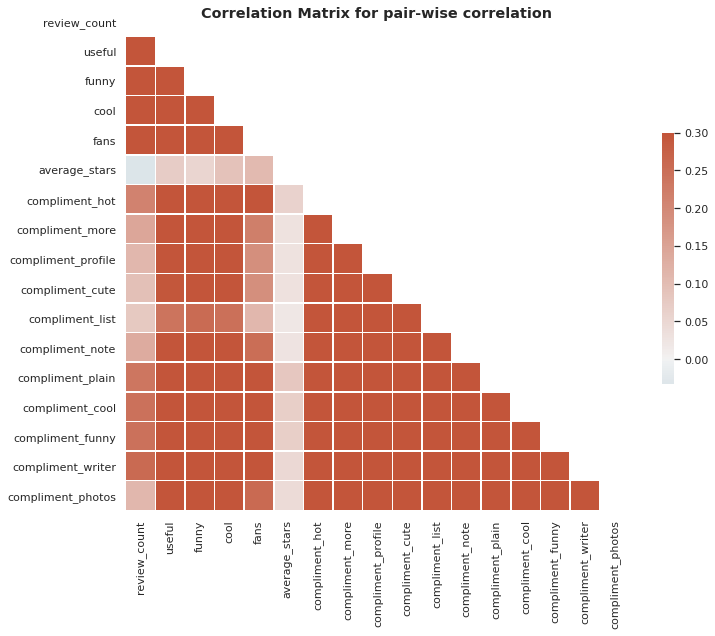

In [124]:
#Correlation Matrix for pair-wise correlation.
corr_matrix = user_df.corr()


#Visualizing the correlations using a Heat map.
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) #mask for omitting the upper triangle

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #Generate a custom diverging colormap
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) #heat map construction with mask

f.suptitle("Correlation Matrix for pair-wise correlation", weight='bold')

plt.tight_layout()


Text(0.5, 1.0, 'Pair-wise correlation with the target variable (average_stars)')

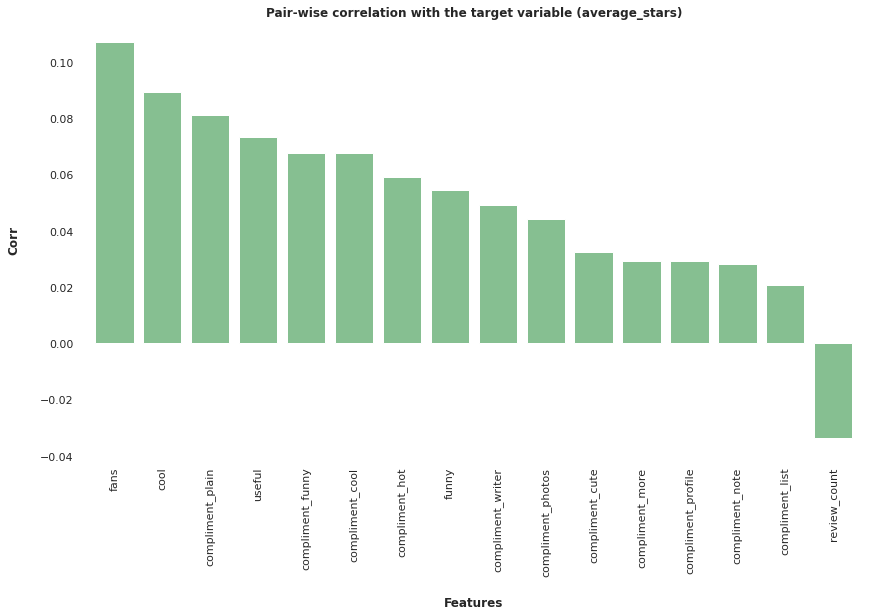

In [123]:
#Pair-wise correlation with the target variable (average_stars)

corr_avg_stars = corr_matrix['average_stars'].sort_values(ascending=False)
corr_avg_stars.pop('average_stars')

#Visualize using a bar plot
ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(14,8), color = '#86bf91', zorder=2, width=0.8)

#Despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20, weight='bold')
ax.set_ylabel('Corr', labelpad=20, weight='bold')

ax.set_title("Pair-wise correlation with the target variable (average_stars)", weight='bold')

We observe that average_stars does not have a strong correlation with any of the other features (except for maybe a weak correlation with review count). For our baseline model <b> we will be taking only the top 3 features from the correlation matrix.</b> 

We wish to take users with the highest review count value, for our baseline model, due the following reasons:  
* <i> Reduction in the size of the datasest </i> - The data currently contains approximately 2 million users, many of whom may not contribute to building an effective recommender system. 
* <i> We want the users with most number of reviews </i> so that we can have a good prediction model as they demonstrate large variance.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Viewing the univariates of user features via distplots')

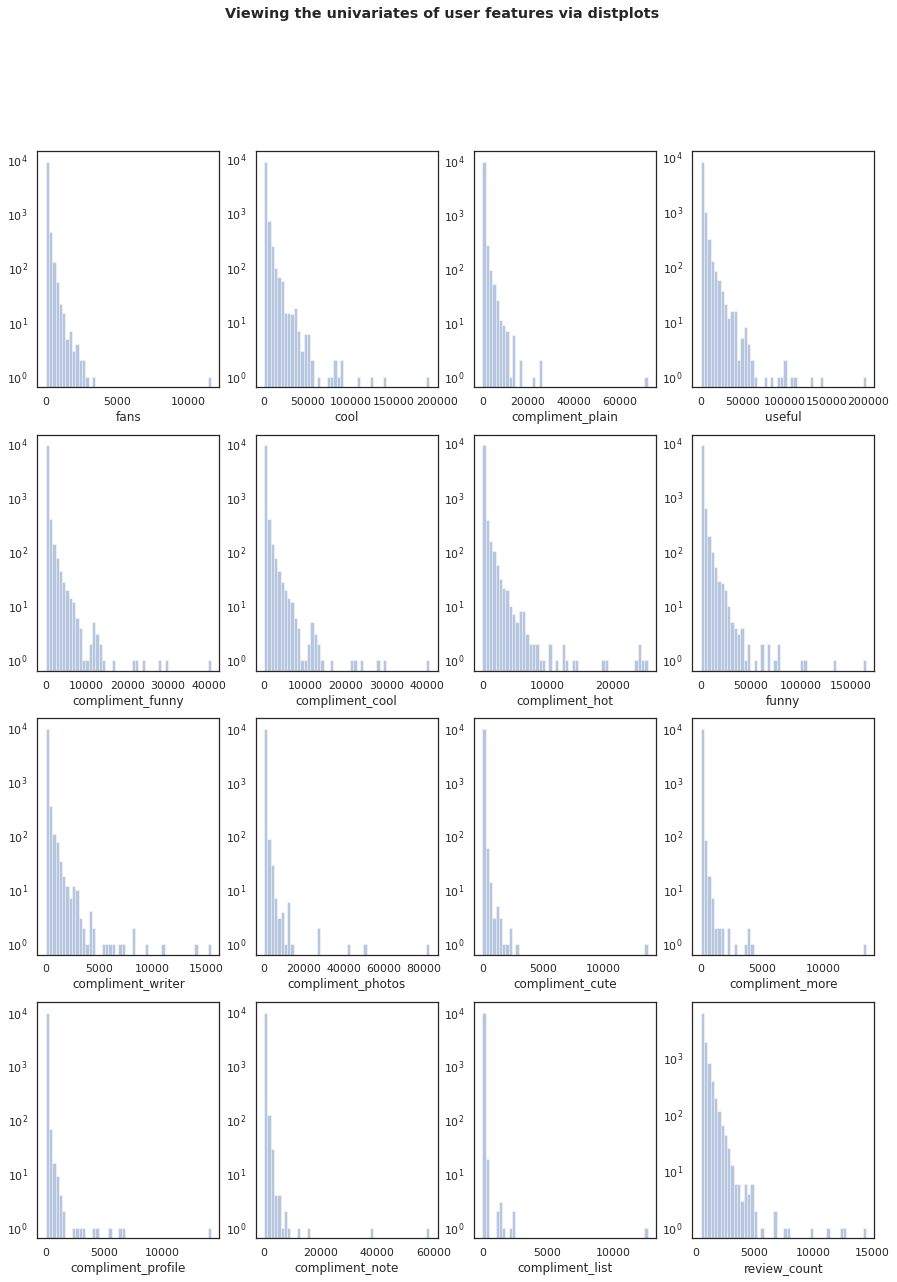

In [125]:
#Viewing the univariates of user features via distplots

fig,axes = plt.subplots(nrows=4, ncols=4, figsize=(15,20))
axes = axes.flatten()
for i, x in enumerate(corr_avg_stars.index):
    sns.distplot(x =user_df[x], kde=False, axlabel=x, label='Density Log scale', ax= axes[i])
    axes[i].set_yscale('log') #log-scale view since the data has a large range 

fig.suptitle("Viewing the univariates of user features via distplots", weight='bold')

Text(0.5, 0.98, 'Viewing the pair-wise spread of user features via scatter plots')

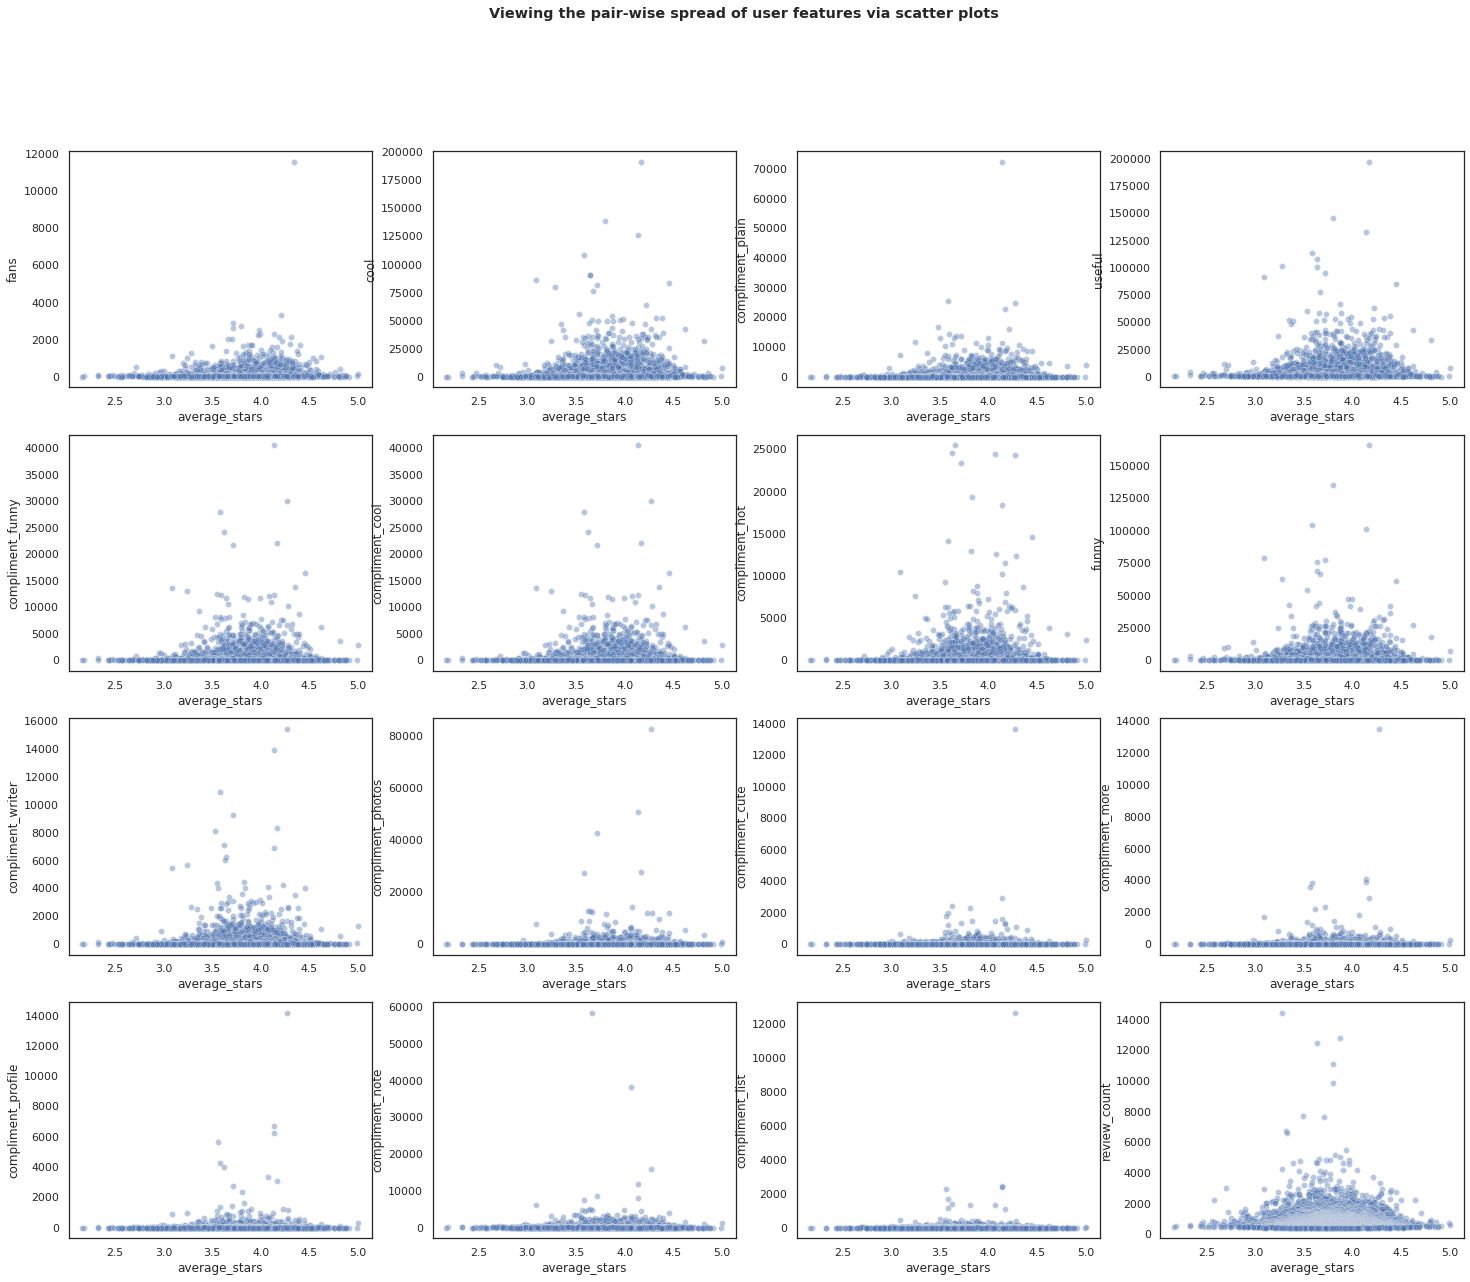

In [126]:
#Viewing the pair-wise spread of user features via scatter plots.

fig,axes = plt.subplots(nrows=4, ncols=4, figsize=(25,20))
axes = axes.flatten()
for i, y in enumerate(corr_avg_stars.index):
    sns.scatterplot(x =user_df['average_stars'], y = user_df[y], ax= axes[i], alpha=0.4)


fig.suptitle("Viewing the pair-wise spread of user features via scatter plots", weight='bold')

<div class="alert alert-block alert-danger" style="color:black;background-color:#ffdead">
<h4 style="color:black;background-color:#ffdead"> Inference </h4>
    <ul>
<li> 1. Most of the plots have similar distribution across average stars and there is not much that seperates one predictor from the other. </li>
<li> 2. Therefore, we have conidered to consider the following columns for our initial baseline model. 
    <ul> 
        <li> <b>Review Count</b> - Based on the fact that it is negetively corelated to other features as seen in the bar plot. And has the highest corelation with the average stars. Therefore we feel it will be our best predictor.</li> 
        <li> <b>Fans</b> - Based on the ba plot, has the second highest correlation with response varible. </li>
        <li> <b>compliment_plain</b> - Out of the compliment_ features this has relatively low corelaitons with other features in the corelation matrix so it might help as perform better. </li> </li>
    </ul>


In [22]:
#Extracting the above-mentioned features and storing the dataframe.
baseline_user_df = user_df[['user_id', 'review_count', 'fans', 'compliment_plain', 'average_stars']]
user_df.to_pickle('user_df.pkl')
baseline_user_df.to_pickle('baseline_user_df.pkl')

### Dataset 2:  The Business Dataset 

In [23]:
business_df = read_json(business_jason_path)
display(business_df.head()) #display rows of the user data
business_df.dtypes #checking data types

business_id  ...                                              hours
0  f9NumwFMBDn751xgFiRbNA  ...  {'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...
1  Yzvjg0SayhoZgCljUJRF9Q  ...                                               None
2  XNoUzKckATkOD1hP6vghZg  ...                                               None
3  6OAZjbxqM5ol29BuHsil3w  ...  {'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ...
4  51M2Kk903DFYI6gnB5I6SQ  ...  {'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...

[5 rows x 14 columns]

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

Let's look at the rating distribution of this huge dataset:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


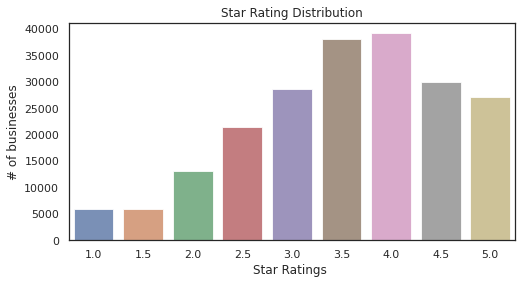

In [24]:
#Plotting Business start ratings versus the Number of Businesses

x=business_df['stars'].value_counts()
x=x.sort_index() #sorting the dataframe based on index value.

#Bar plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

plt.show();

### Subsequent steps

 * We find the top 10 business categories and the distribution of restaurants in different places. 
 * Select the city with the highest number of restaurants. 

#### Decisions Made: 
First, we <b> eliminate all the cases where the business has no categories </b>. We then get hold of the categories and construct plots to have a look at which categories have a decent amount of holding in the dataset. Based on this, we will get hold of top categories and further progress with our data analysis.

In [28]:
#Implementing the steps detailed above

#detect non-missing values
business_df= business_df[business_df['categories'].notna()] 

categ=';'.join(business_df['categories'])
cat=re.split(';|,', categ)
business_categories=pd.DataFrame([item.strip() for item in cat],columns=['category']) #getting hold of the categories in the dataset

#Top 10 categories based on value counts.
businesscount=business_categories.category.value_counts().sort_values(ascending = False)[:10] 
businesscount

Restaurants         63944
Shopping            34644
Food                32991
Home Services       22487
Beauty & Spas       20520
Health & Medical    19227
Local Services      15783
Automotive          14720
Nightlife           14211
Bars                12400
Name: category, dtype: int64

Since we are going to exclusively deal with the restaurants, we will take the subset of the cases where the business is just Restaurant type:

In [29]:
#Fetching only the restaurants that are present in the business dataset.
Restaurants = business_df.loc[[i for i in business_df['categories'].index if re.search('Restaurants', business_df['categories'][i])]]

### Reference - https://www.kaggle.com/dehaozhang/yelp-eda

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


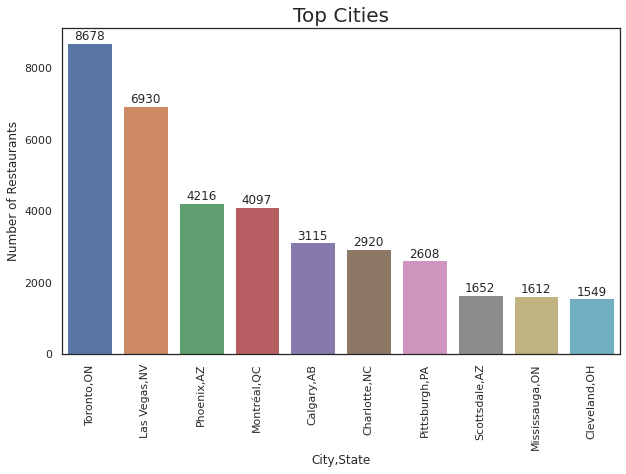

In [30]:
#Plotting Count of Businesses across Top 10 cities (global).

Restaurants['city_state'] = Restaurants['city'] + ',' + Restaurants['state']
#Restaurant counts for top 10 cities
city_count = Restaurants.city_state.value_counts().sort_values(ascending = False)[:10] 

# Bar-plot 
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(city_count.index, city_count.values)
plt.title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('City,State', fontsize = 12)

#Labelling the plot
r = ax.patches
labels = city_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

We see that <b> Toronto,Ontario </b> has the highest number of restaurants, followed by Las Vegas, Phoenix City and the rest. <i> The Toronto subset also has an error where the state is mispelled as OH instead of ON </i>. We cater to this error and handle it in later steps.

### Decisions Made:
* <b> Considering Toronto has the highest number of Restaurants, we subset our restaurant navigation further to just Toronto.</b>
* Consider only those restaurants which are open in Toronto.

In [31]:
# Extract Toronto Restaurants and store the dataframe
toronto_df=Restaurants[Restaurants.city=='Toronto'] 
toronto_df.to_pickle('Toronto_rest')


(5462, 9)

In [127]:
toronto_df = pd.read_pickle('Toronto_rest')

#Incorporate the decisions mentioned above
toronto_df=toronto_df.drop(['address','city','state','hours','city_state'],axis=1) #Dropping columns that are not useful
toronto_df=toronto_df[toronto_df.is_open==1] #take only those restaurants which are open
toronto_df=toronto_df.drop('is_open',axis=1) #drop is_open column 
toronto_df.shape

(5462, 9)

Now, we notice that each business has multiple branches or outlets in Toronto, such as Tim Hortons, which has 58 instances with various ratings. This brings us to a plotting or analysis junction where we can see which businesses have the highest number of outlets in Toronto.

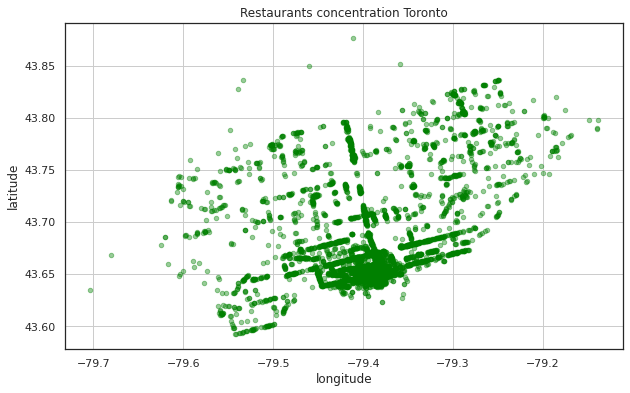

In [128]:
#Restaurant Concentration across Toronto

f, ax = plt.subplots(1, 1, figsize=(10,6))

#coordinates for Toronto from Google
lat_t = 43.6532
lon_t = -79.3832
#Latitude and Longitude extremeties
lon_t_min, lon_t_max = lon_t-0.5,lon_t+0.5
lat_t_min, lat_t_max = lat_t-0.5,lat_t+0.5

#subset the data
map_=toronto_df[(toronto_df["longitude"]>lon_t_min) & (toronto_df["longitude"]<lon_t_max) &\
                    (toronto_df["latitude"]>lat_t_min) & (toronto_df["latitude"]<lat_t_max)]

#plotting
map_.plot(kind='scatter', x='longitude', y='latitude',
                color='green',alpha=0.4, ax=ax)
ax.grid('off')
ax.set_title("Restaurants concentration Toronto");

**Plotting the top 20 restaurants of Toronto**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


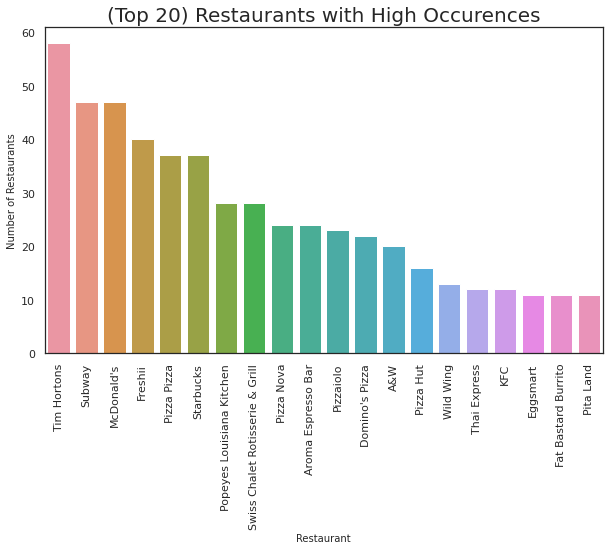

In [129]:
#Plotting the top 20 restaurants of Toronto

#Counting each of the restaurants in toronto
TopRes = toronto_df.name.value_counts().sort_values(ascending = False)[:20]


#Barplot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(TopRes.index, TopRes.values)
plt.title("(Top 20) Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 10)
plt.xlabel('Restaurant', fontsize = 10);

From the plot, we see that Tim Hortons and Mc Donalds, followed by Subway, lead the graph with the highest number of occurences.These businesses seem to have opened lot of franchises/branches in the city. <i> Note that this doesn't necessarily mean that they have a strong positive response from the users </i> in that aspect. We look into that as well in some of our EDA.

**Plotting the ratings obtained by Restaurants of the top 20 Restaurants:**


We plot the average ratings and their standard deviations using box-plots for the top 20 restaurants

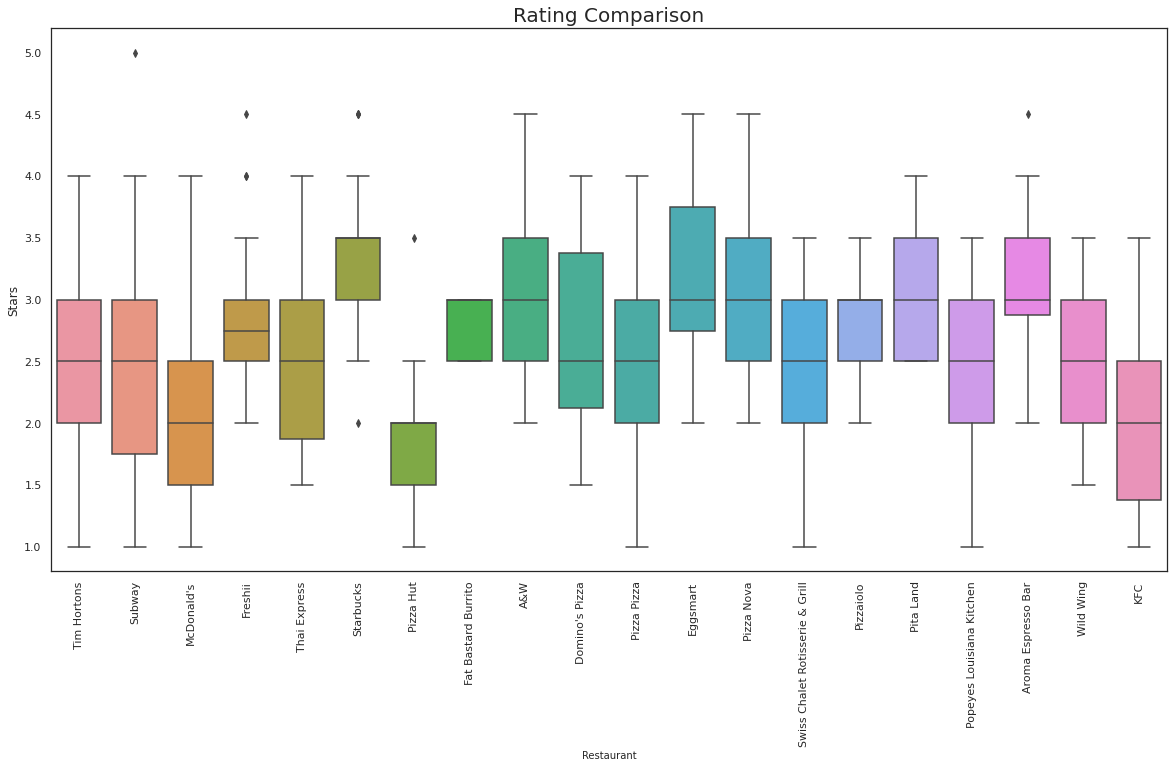

In [130]:
#Boxplot of rating ranges and means of different food chains.
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x = 'name', y = 'stars', data = toronto_df[toronto_df.name.isin(TopRes.index)])
plt.title("Rating Comparison",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

This boxplot gets us the mean ratings and the range of ratings received by each of these restaurants. There are a certain number of outliers in case of a few restaurants and for most of them,the outliers are high rankings, which is a good thing! :)

**Further, there is a relation between the stars received by the restaurants and review counts:**

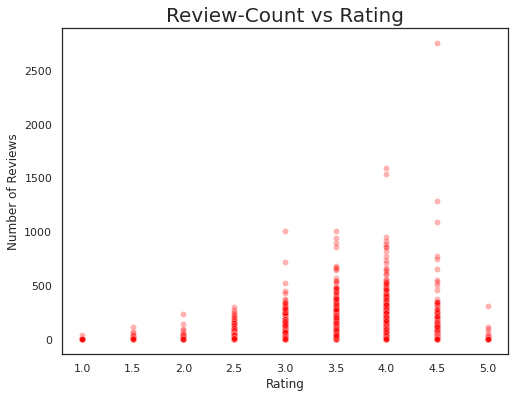

In [131]:
#Plotting the No. of reviews versus ratings
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'stars', y = 'review_count',color='red',alpha=0.3 ,data = toronto_df)
plt.title("Review-Count vs Rating",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Rating', fontsize = 12);

We see that the review count is mostly concentrated in the lower regions i.e, lolwer values of no. of reviews. Most ratings are based on less number of reviews and quite a few have received a high rating where the review count is also high. Let's look at the Restaurants where the **review count is more than 500 and the rating is above 3.5**!

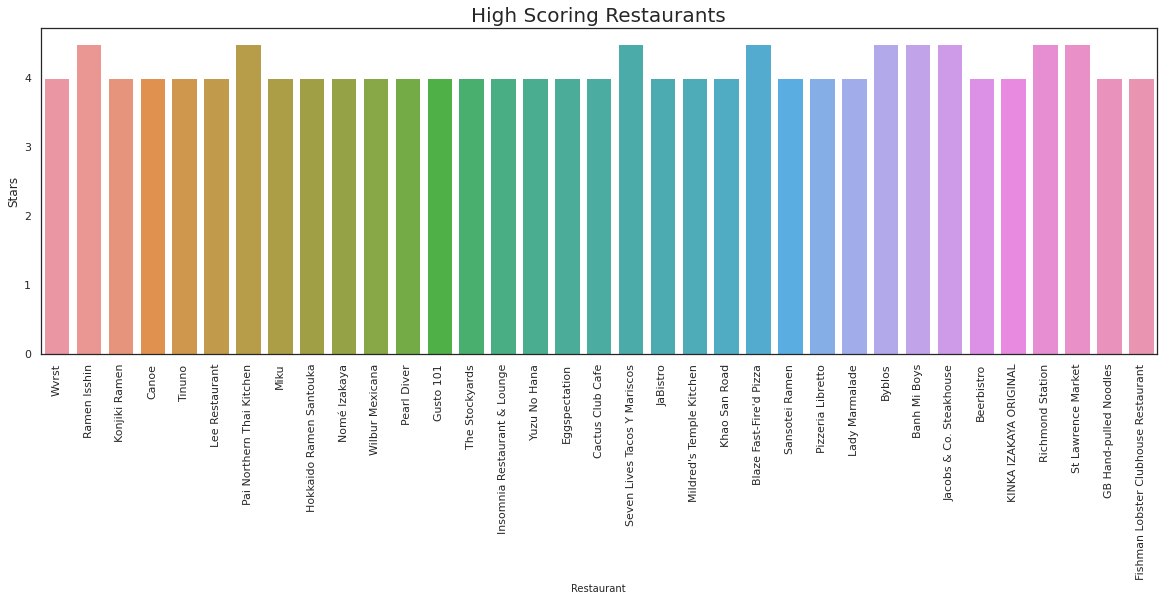

In [132]:
#Ratings of Restaurants with review count>500 and rating> 3.5

df=toronto_df[(toronto_df.stars>3.5) &(toronto_df.review_count>500)]
fig,ax=plt.subplots(figsize=(20,6))
sns.barplot(data=df,x=df.name,y=df.stars,ax=ax)
plt.title("High Scoring Restaurants",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);


These few restaurants have received a high rating as well as have a good number of reviews. Not only do these restaurants have a strong user base but they also seem to be liked by the users.

For our baseline model we would like to get some columns from the exisitng dataset to try and predict the average rating to be given to that resturants. We will later turn to indepth analysis where we feature engineer and expand multiple columns. 

In [133]:
#A quick glimpse of the toronto dataset
display(toronto_df.head())
toronto_df.dtypes

business_id  ...                                         categories
73   0QjROMVW9ACKjhSEfHqNCQ  ...                            Vietnamese, Restaurants
110  8k62wYhDVq1-652YbJi5eg  ...  Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...
149  0DnQh8SE8BSnvJltGCCiWg  ...               Fast Food, Restaurants, Chicken Shop
150  NLaK58WvlNQdUunSIkt-jA  ...        Coffee & Tea, Restaurants, Sandwiches, Food
161  cicPsia8Wj-DNRkmLbD_xg  ...  Steakhouses, Restaurants, Nightlife, Seafood, ...

[5 rows x 9 columns]

business_id      object
name             object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
attributes       object
categories       object
dtype: object

In [134]:
#Dropping restaurant attributes for the initial EDA
baseline_toronto_df = toronto_df.drop(columns = ['attributes'], axis =1)
#View feature report
table_report(baseline_toronto_df)

Table Shape (5462, 8)


Text(0.5, 0.98, 'Pair-wise correlations for the toronto restaurant dataframe')

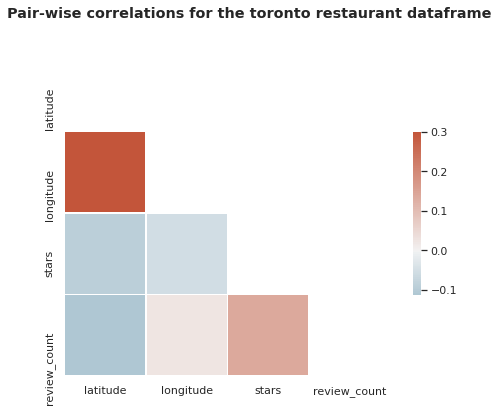

In [136]:
#Pair-wise correlations for the toronto restaurant dataframe

corr_baseline_toronto = baseline_toronto_df.corr()
corr_baseline_toronto

sns.set_theme(style="white")


# Visualizing the correlations using a Heat Map
mask = np.triu(np.ones_like(corr_baseline_toronto, dtype=bool)) #mask for the upper triangle
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Generate a custom diverging colormap

sns.heatmap(corr_baseline_toronto, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) #Heatmap

f.suptitle("Pair-wise correlations for the toronto restaurant dataframe", weight="bold")

### Dataset 3 & 4:  The Tips Dataset and The Large User Dataframe


In [40]:
#Load the tips dataset and check data types
tip_df = read_json(tip_json_path)
display(tip_df.head(3))
print(tip_df.dtypes)

# Load the large user_df dataset and check data types
user_df_large = read_json(user_json_path)
display(user_df_large.head(3))
user_df_large.dtypes

user_id  ... compliment_count
0  hf27xTME3EiCp6NL6VtWZQ  ...                0
1  uEvusDwoSymbJJ0auR3muQ  ...                0
2  AY-laIws3S7YXNl_f_D6rQ  ...                0

[3 rows x 5 columns]

user_id             object
business_id         object
text                object
date                object
compliment_count     int64
dtype: object


user_id      name  ...  compliment_writer compliment_photos
0  ntlvfPzc8eglqvk92iDIAw    Rafael  ...                 10                 0
1  FOBRPlBHa3WPHFB5qYDlVg  Michelle  ...                 21                 5
2  zZUnPeh2hEp0WydbAZEOOg    Martin  ...                  4                 1

[3 rows x 22 columns]

user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

In [41]:
#Pre-processing the tip_df

#Change the 'date' type to datetime format. 
tip_df['date'] = pd.to_datetime(tip_df['date'], infer_datetime_format=True)

#Obtaining the year, month and date (separately) when the tip was given.
tip_df['tip_year'] = pd.DatetimeIndex(tip_df['date']).year
tip_df['tip_month'] = pd.DatetimeIndex(tip_df['date']).month
tip_df['tip_day_of_month'] = pd.DatetimeIndex(tip_df['date']).day


# Convert the tip_year and compliment count to categorical dtype
#Change compliment count to a zero indicator variable.
tip_df['tip_year'] = tip_df.tip_year.astype('category')
tip_df['tip_month'] = tip_df.tip_month.astype('category')
tip_df['compliment_count'] = tip_df.compliment_count.astype('category')


#Visualize report
table_report(tip_df)

Table Shape (1320761, 8)


#### Pre-processing

We have done following feature engineering in our dataframe for the reasons listed below: 
1. yelping_since_year : We have taken the year from the yelping_since column which earlier had a time stamp. In this way, we are able to categorize how many users are yelping since each year. We have also changed this to a categorical variable. 

2. no_of_friends : The dataset had a column friends with user_id's of people the user is friends with. We have simply taken into account how many friends the user has on yelp. At a later stage we would like to see how user-user mapping can be used to make a better recommendation system, but we will consider this as out of scope for our baseline model. 

3. no_of_years_elite : The column listed the years where the user was considered an elite user. We have opted to keep the information as how many years the user was rated elite. We have changed this column to categorical pertaining to its low cardinality.

4. We have dropped the columns 'friends', 'elite', 'yelping_since', 'name'. 

5. We have kept all the attributes listed by yelp about the user as there might be some information as to how the user will rate a particular rest. based based on these features. We plan to discretize these varibles in the later parts of the EDA 

In [42]:
#Pre-processing the user_df_large dataframe

#Converting yelping_since_year to datetype
user_df_large['yelping_since'] = pd.to_datetime(user_df_large['yelping_since'], infer_datetime_format=True)
user_df_large['yelping_since_year'] = pd.DatetimeIndex(user_df_large['yelping_since']).year #obtain only year

#Number of friends (count) from the friends column 
user_df_large['no_of_friends'] = user_df_large['friends'].apply(lambda x: len(x.split(',')))
#Number of elite years from the elite column 
user_df_large['no_of_years_elite'] = user_df_large['elite'].apply(lambda x: len(x.split(','))) #change to zero indicator variable


#Drop the older friends and elite column as they are no longer required 
drop_cols = ['friends', 'elite', 'yelping_since', 'name']
user_df_large = user_df_large.drop(columns = drop_cols, axis=1)
print(user_df_large.shape)

# For features with low cardinality, we change the data type to categorical.
user_df_large['yelping_since_year'] = user_df_large.yelping_since_year.astype('category')
user_df_large['no_of_years_elite'] = user_df_large.no_of_years_elite.astype('category')

(1968703, 21)


In [43]:
#Join the tip dataframe and our user_df_large dataframe to get the tips associated with users.
combined_df = tip_df.merge(user_df_large, how='inner', on='user_id')

#Join the combined_df with the Toronto business dataframe to get the business mappings.
df_user_toronto = combined_df.merge(toronto_df['business_id'], how='inner', on='business_id')

#visualise report
table_report(df_user_toronto)     

Table Shape (41097, 28)


***

## Feature Engineering

In [44]:
#We first flatten the attributes part of the dataset which holds dictionary of the various attributes of the businesses.
toronto_df['attributes'] = toronto_df['attributes'].apply(lambda x: {} if x is None else x)

#Flattening out the attributes column
df = pd.json_normalize(toronto_df.attributes)

We see that there are also columns like **BusinessParking, GoodForMeal** which need to be further flattened and we use the **atomicrows2** function below to do that.

In [45]:
# Function to split the desired column and adding a prefix to the split columns

def atomicrows2(df,target_column,pre):

    def splitListToRows(row,row_accumulator,target_column,pre):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row[pre+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,pre))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [46]:
#Calling the above function to GoodForMeal, BusinessParking, Music, BestNights and DietaryRestrictions.

df = atomicrows2(df, 'GoodForMeal','meal_')
df.drop('GoodForMeal',axis=1,inplace=True)

df = atomicrows2(df, 'BusinessParking','bpark_')
df.drop('BusinessParking',axis=1,inplace=True)

df = atomicrows2(df, 'Music','m_')
df.drop('Music',axis=1,inplace=True)

df = atomicrows2(df, 'BestNights','bn_')
df.drop('BestNights',axis=1,inplace=True)

df = atomicrows2(df, 'DietaryRestrictions','dr_')
df.drop('DietaryRestrictions',axis=1,inplace=True)

print(df.shape)
display(df.head(3))
df.columns[33:]

(5462, 64)


RestaurantsTakeOut           Alcohol  ... dr_soy-free dr_vegetarian
0               True  u'beer_and_wine'  ...         NaN           NaN
1               True            'none'  ...         NaN           NaN
2               True            'none'  ...         NaN           NaN

[3 rows x 64 columns]

Index(['meal_latenight', 'meal_lunch', 'meal_dinner', 'meal_brunch',
       'meal_breakfast', 'bpark_garage', 'bpark_street', 'bpark_validated',
       'bpark_lot', 'bpark_valet', 'm_dj', 'm_background_music', 'm_no_music',
       'm_jukebox', 'm_live', 'm_video', 'm_karaoke', 'bn_monday',
       'bn_tuesday', 'bn_friday', 'bn_wednesday', 'bn_thursday', 'bn_sunday',
       'bn_saturday', 'dr_dairy-free', 'dr_gluten-free', 'dr_vegan',
       'dr_kosher', 'dr_halal', 'dr_soy-free', 'dr_vegetarian'],
      dtype='object')

In [47]:
#Handling null values

mod_cols = df.columns[32:]
df[mod_cols] = df[mod_cols].fillna('False') #Null handling using False.
for i in mod_cols:
    df[i].replace('None','False',inplace=True) #imputations of the similar kind based on data observation


#Ttable report on the split columns to cross-check the null-cases.
table_report(df)

Table Shape (5462, 64)


In [48]:
#Using the atomicrows function, we get hold of the dictionary inside the ambience key of the attributes 
#dictionaries and flatten it in order to get hold of the different ambiences provided by the different 
#restaurants.

def atomicrows(df,target_column):

    def splitListToRows(row,row_accumulator,target_column):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column]['Ambience'].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row["amb_"+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [49]:
df2 = atomicrows(toronto_df,'attributes')

#Table report to see the different null values for the split columns (we will subsequently handle those).
amb_cols = df2.columns[9:]
df2[amb_cols] = df2[amb_cols].fillna('False') #replace Nulls with False
for i in amb_cols:
    df2[i].replace('None','False',inplace=True)

#Display report    
display(table_report(df2[amb_cols]))

#Store dataframe
df2.to_pickle('toronto_restaurant_amb_added')

Table Shape (5462, 9)


None

In [50]:
#Reading the pre-processed toronto_restaurant dataframe 

restaurants = pd.read_pickle('toronto_restaurant_amb_added')
restaurants=restaurants[restaurants.attributes.notnull()] #dropping restaurants with no attributes to work on
print(restaurants.shape)

#Now, we combine the 2 flattened DF to get a df which has all the attributes fully flattened.
#This becomes our base dataframe for modeling!
res = pd.merge(restaurants,df,left_index=True,right_index=True)
print(res.shape)
res.head(3)

(5462, 18)
(5462, 82)


business_id              name  ... dr_soy-free  dr_vegetarian
0  0QjROMVW9ACKjhSEfHqNCQ  Mi Mi Restaurant  ...       False          False
1  8k62wYhDVq1-652YbJi5eg       Tim Hortons  ...       False          False
2  0DnQh8SE8BSnvJltGCCiWg       Chick-N-Joy  ...       False          False

[3 rows x 82 columns]

In [51]:
#We drop the Ambience and attributes columns since we have already flattened them out. 
#Also, we drop the column HairSpecializesIn since it makes no sense to include that attribute in the rating
#of a restaurant.

res.drop('Ambience',axis=1,inplace=True)
res.drop('HairSpecializesIn',axis=1,inplace=True)
res.drop('attributes',axis=1,inplace=True)


#Flatten the attributes and handle the NaN: Impute certain values and handle the missing values accordingly.

res['RestaurantsPriceRange2']=res['RestaurantsPriceRange2'].replace(np.nan,0) #replace nan with 0
res['RestaurantsAttire']=res['RestaurantsAttire'].replace(np.nan,"streets") #replace nan with "streets"
res['Alcohol']=res['Alcohol'].replace(np.nan,"u'none'") #replace nan with "none"
res['Caters']=res['Caters'].replace(np.nan,"False") #replace nan with False

for i in res.columns[13:]:
  res[i]=res[i].replace(np.nan,"False")
  res[i].replace('None','False',inplace=True)


The below-mentioned columns **WiFi, Smoking, RestaurantsAttire, Alcohol, NoiseLevel, RestaurantsPriceRange2** had some anomalies as discovered using the table report function and we have accordingly handled those anomalies (like unicode string, having same words with quotes etc.)

In [52]:

res['WiFi'] = res['WiFi'].apply(lambda x: x.encode('utf-8').decode('utf-8').strip().replace('\'', ""))
res['WiFi'] = res['WiFi'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['WiFi'].replace('no','False',inplace=True)
res['WiFi'].replace("'paid'",'paid',inplace=True)

res['Smoking'] = res['Smoking'].apply(lambda x: x.encode('utf-8').decode('utf-8').strip().replace('\'', ""))
res['Smoking'] = res['Smoking'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['Smoking'].replace('no','False',inplace=True)

res['RestaurantsAttire'] = res['RestaurantsAttire'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['RestaurantsAttire'].replace("False","streets",inplace=True)

res['Alcohol'] = res['Alcohol'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
res['Alcohol'] = res['Alcohol'].apply(lambda x: x[1:] if x[0]=="u" else x )
res['Alcohol'].replace('False','none',inplace=True)

res['NoiseLevel'] = res['NoiseLevel'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
res['NoiseLevel'] = res['NoiseLevel'].apply(lambda x: x[1:] if x[0]=="u" else x )

res['RestaurantsPriceRange2'].replace('False',0,inplace=True)

In [53]:
#Convert the required columns to categoricals 
for i in res.columns[9:]:
  res[i]=res[i].astype('category').cat.codes.values

#Store the pre-processed dataframe
res.to_pickle("Toronto_Rest_Flat_Clean")

#View table report
table_report(res)

Table Shape (5462, 79)


## Exploratory Data Analysis (Second Phase) 
Let's explore the Toronto_Rest_Flat_Clean dataframe, obtained after feature-engineering.

In [137]:
res = pd.read_pickle("Toronto_Rest_Flat_Clean") 

In [138]:
#Pearsonr coefficient correlation

cols = res.columns[9:]
df_list=[]

for i in cols:
    #Finding the pearsonr coefficient between the stars column and the attributes
    value = pearsonr(res[i],res['stars'])
    corr = {'Feature':i , 'corr':value[0] , 'abscorr':abs(value[0])} #correlation and absolute correlation
    df_list.append(corr)

df_corr = pd.DataFrame(df_list)
corr=df_corr.sort_values(by='abscorr',ascending=False)[:25] #sort dataframe in descending order of corr
corr

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Feature      corr   abscorr
45             bpark_street  0.203068  0.203068
20  RestaurantsTableService  0.136863  0.136863
25     WheelchairAccessible  0.127637  0.127637
1                amb_classy  0.123654  0.123654
22                   Caters  0.123254  0.123254
19              BikeParking  0.120480  0.120480
41              meal_dinner  0.113992  0.113992
7                amb_casual  0.092395  0.092395
40               meal_lunch  0.092316  0.092316
15  RestaurantsReservations  0.090806  0.090806
18                     WiFi  0.086418  0.086418
9                   Alcohol -0.078187  0.078187
5                amb_trendy  0.076049  0.076049
2               amb_hipster  0.067677  0.067677
12        RestaurantsAttire  0.053987  0.053987
23                DriveThru -0.053675  0.053675
0              amb_intimate  0.053160  0.053160
16           OutdoorSeating  0.052603  0.052603
13      RestaurantsDelivery -0.050102  0.050102
17               NoiseLevel -0.048154  0.048154
42              meal_brunch  0.046940  0.046940
24              DogsAllowed  0.039680  0.039680
21                    HasTV -0.036463  0.036463
26                HappyHour  0.035606  0.035606
11   RestaurantsPriceRange2  0.034999  0.034999

The pearsonr function helps us to find the correlation between several attributes and stars and see if any of them have a effect on the ratings given by the users and then, we print the top 25 of them based on the absolute value of the correlation, irrespective, of whether positive or negative correlation.

Text(0, 0.5, 'Correlation Value')

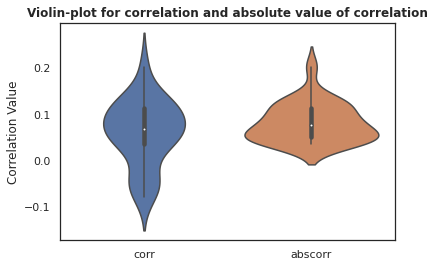

In [146]:
#Distribution of the correlations
fig = sns.violinplot(data=corr)
fig.set_title("Violin-plot for correlation and absolute value of correlation",weight="bold")
fig.set_ylabel("Correlation Value")

###### We make plots to see more clearly which factors are influencing the star rating

Text(0.5, 1.0, 'Bar plot for the correlations between the attribute features and stars')

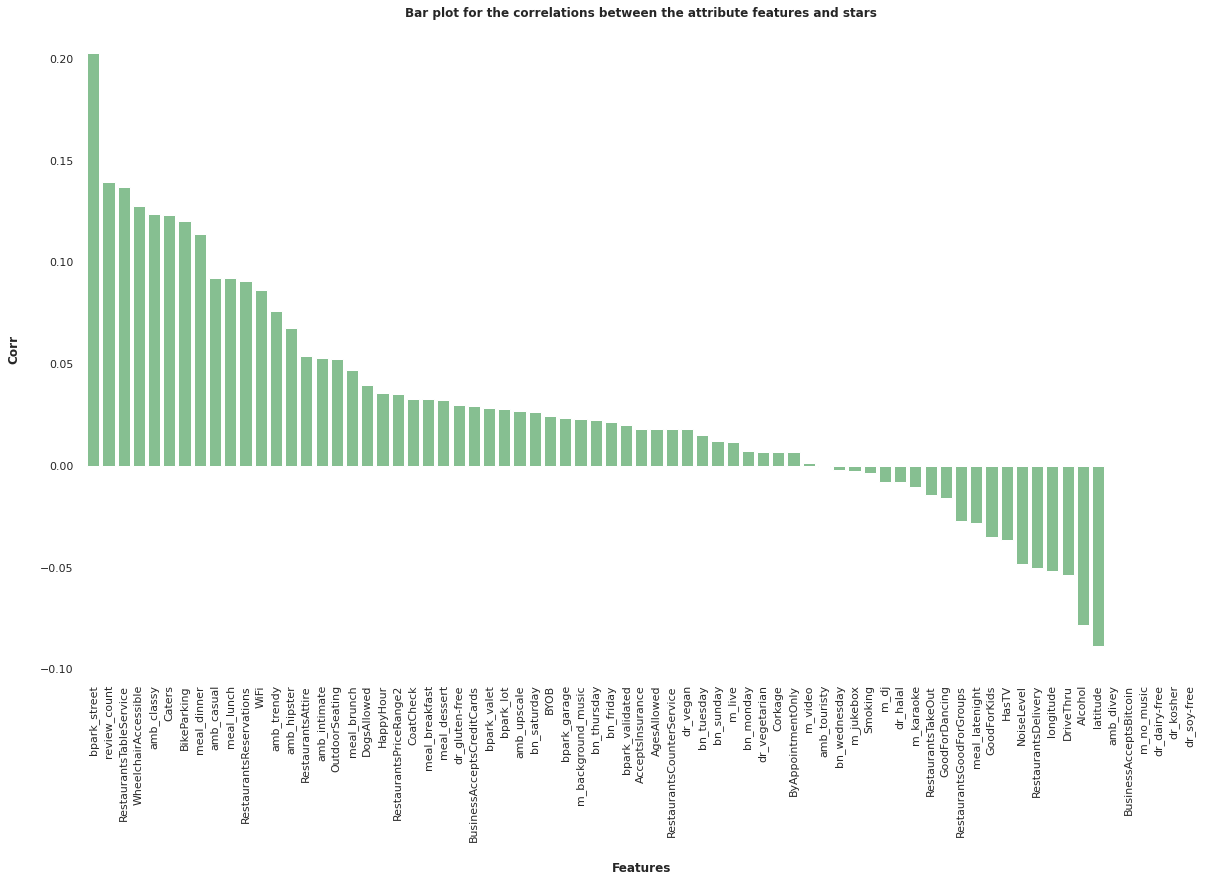

In [150]:
corr_matrix = res.corr()

#correlation matrix between the attributes
corr_avg_stars = corr_matrix['stars'].sort_values(ascending=False)
corr_avg_stars.pop('stars')

#Visualize a bar plot for the correlations between the attribute features and stars.
ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(20,12), color = '#86bf91', zorder=2, width=0.8)

#despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20 , weight="bold")
ax.set_ylabel('Corr', labelpad=20, weight="bold")
ax.set_title("Bar plot for the correlations between the attribute features and stars", weight="bold")

The first 10 seem to be quite important attributes that need to be in our dataset for further Feature Engineering 

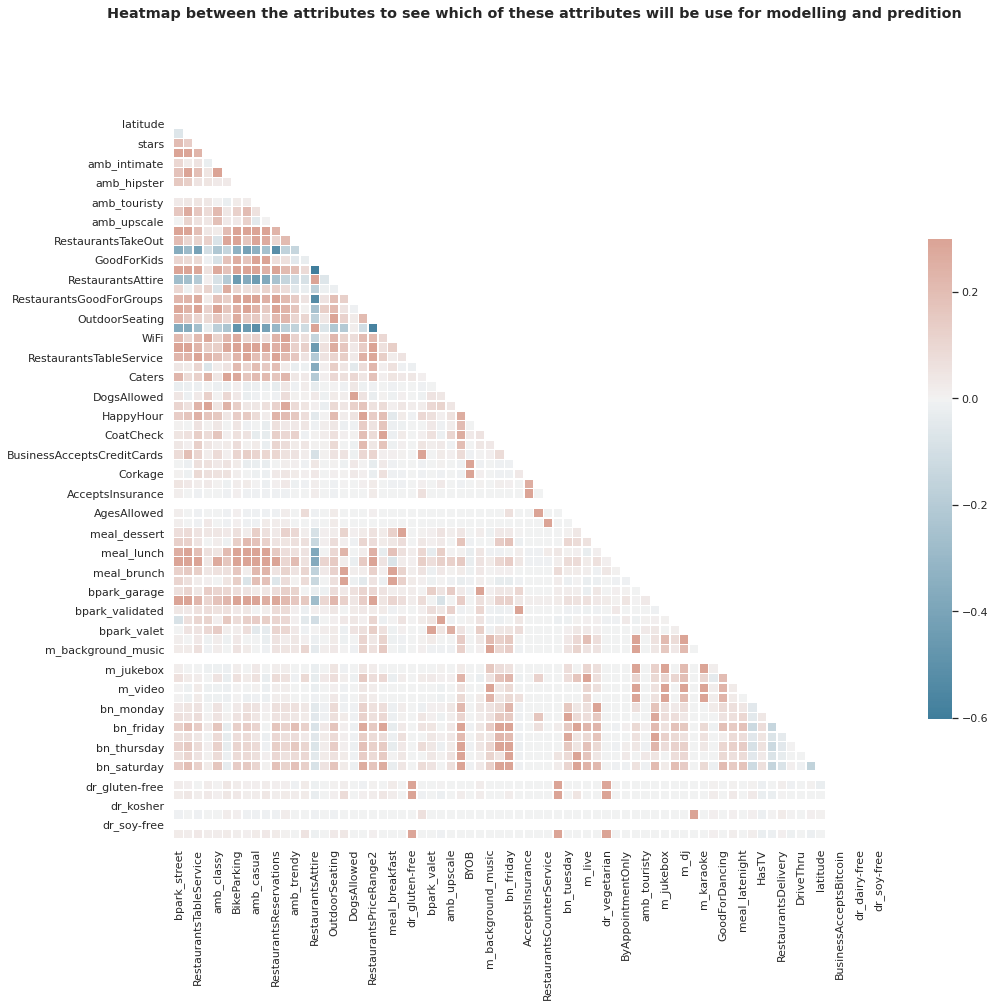

In [152]:
#Heatmap between the attributes to see which of these attributes will be use for modelling and predition.

sns.set_theme(style="white")
mask = np.triu(np.ones_like(res.corr()[corr_avg_stars.index], dtype=bool)) #upper triangle mask
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True) #Generate a custom diverging colormap

sns.heatmap(res.corr()[corr_avg_stars.index], mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) # Heatmap with the mask 

f.suptitle("Heatmap between the attributes to see which of these attributes will be use for modelling and predition", weight="bold")
plt.tight_layout()


Apparently, bpark_street,review_count,RestaurantsTableService,GoodForDancing,amb_classy, alcohol, WheelchairAccessible seem important attributes,to keep in our dataset.

Text(0.5, 0.98, 'Scatter plots to study the spread of datapoints, plotting each feature wrt stars')

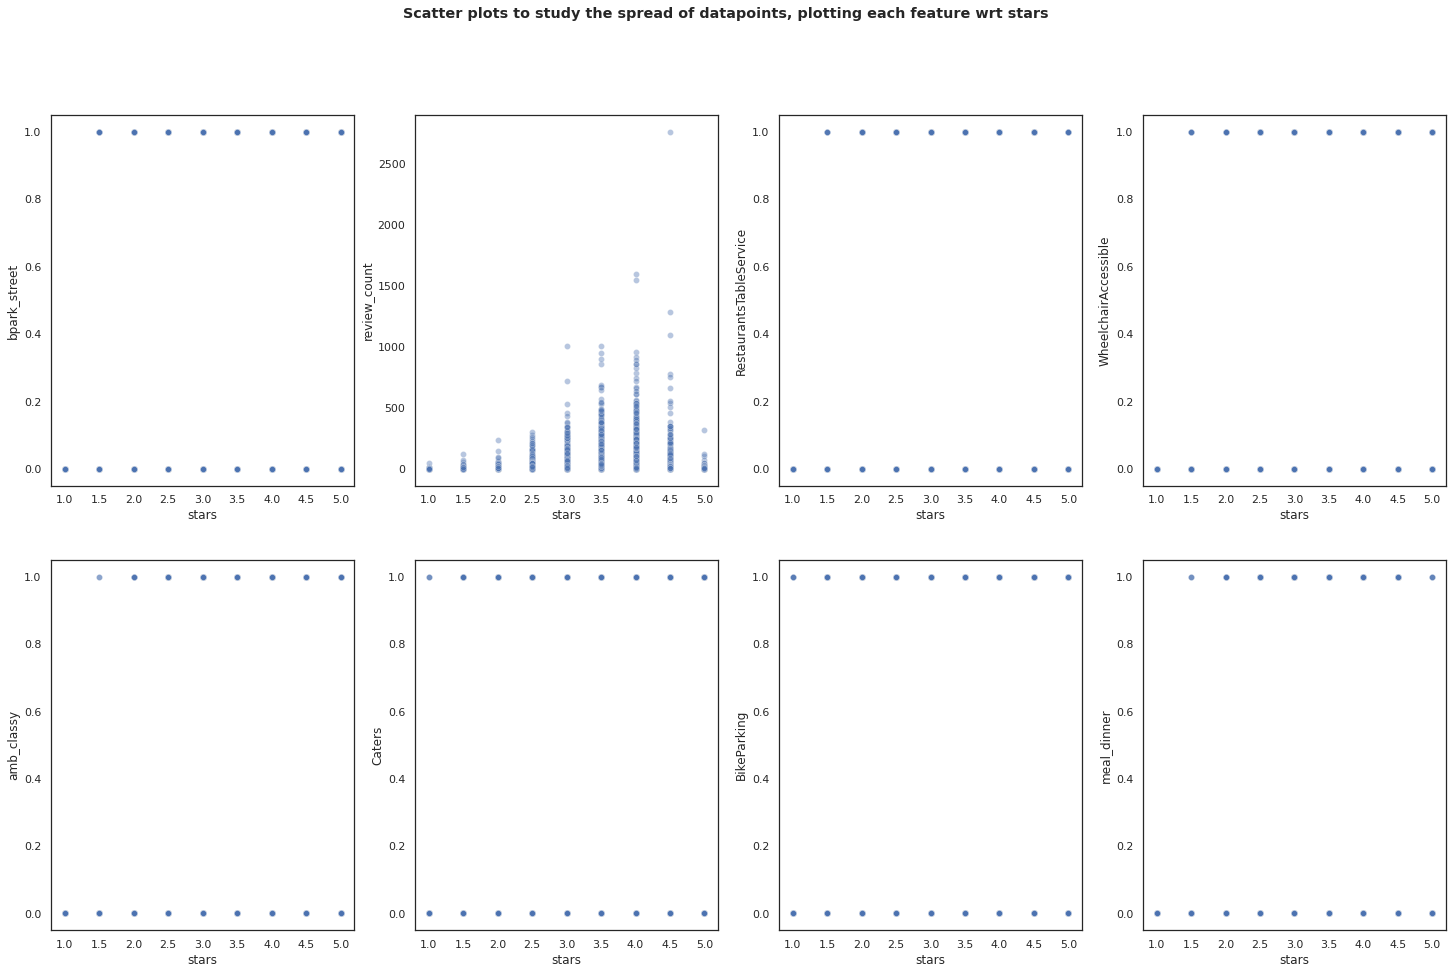

In [155]:
#Scatter plots to study the spread of datapoints, plotting each feature w.r.t stars.

fig,axes = plt.subplots(nrows=2, ncols=4, figsize=(25,15))
axes = axes.flatten()
for i, y in enumerate(corr_avg_stars.index[:8]):
    sns.scatterplot(x =res['stars'], y = res[y], ax= axes[i], alpha=0.4)

fig.suptitle("Scatter plots to study the spread of datapoints, plotting each feature wrt stars", weight="bold")

In [157]:
# Flatten the category column in order to increase more number of latent Factors in our Data.

df = pd.Series(res['categories']).str.get_dummies(',')
df.columns = df.columns.str.strip()
df.drop(['Food','Restaurants'],axis=1,inplace=True)
df.shape

#Join the ratings to the flattened dataframe above
ratings=pd.DataFrame(res[['stars','categories']],index=res.index,columns=['stars','categories'])
ratings=pd.merge(ratings,df,left_index=True,right_index=True)
ratings.head(3)

stars  ... Yelp Events
0    4.0  ...           0
1    3.0  ...           0
2    3.0  ...           0

[3 rows x 547 columns]

The ratings Dataset has 547 columns which, if added further to increase the number of latent factors for the businesses doesn't really help,as <i> they are sparsely valued and might just add to more mis-specification without any improvement. Hence, we keep them notably, away from our business data, now the 'res' dataset.</i>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


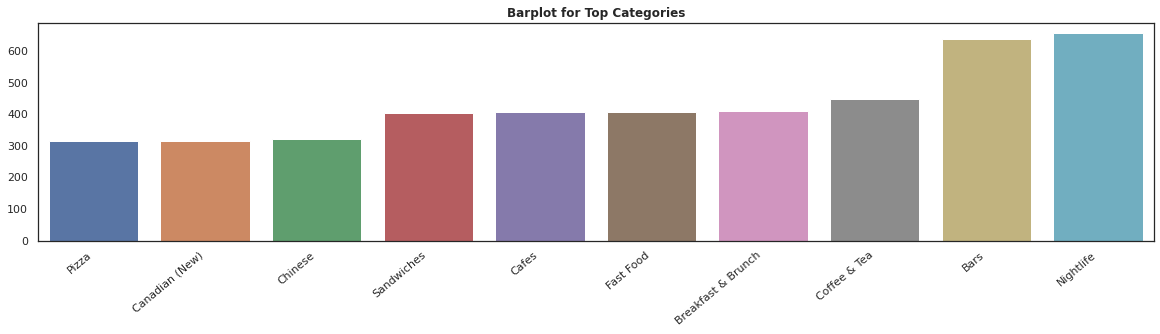

In [159]:
#EDA on the categories obtained 

#Barplot for Top Categories
top_cats = df.sum().sort_values()[-10:]

plt.figure(figsize=(20,4))
ax = sns.barplot(top_cats.index,top_cats.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Barplot for Top Categories",weight="bold")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of reviews for each star rating')

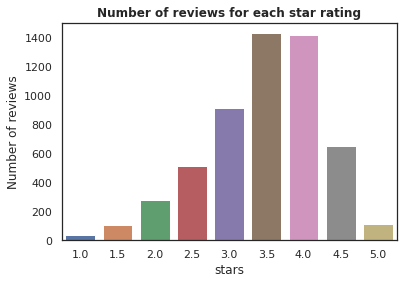

In [161]:
ratings = res.groupby('stars').count()['review_count']
fig = sns.barplot(ratings.index,ratings.values)
fig.set_ylabel("Number of reviews")
fig.set_title("Number of reviews for each star rating",weight="bold")

Text(0.5, 1.0, 'Log Distribution of Review Count')

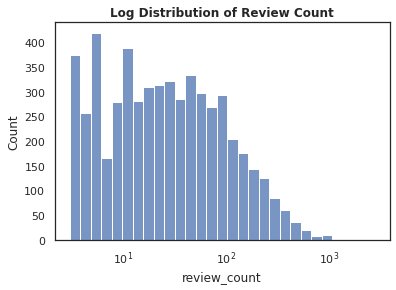

In [162]:
fig = sns.histplot(res['review_count'],log_scale=True)
fig.set_title("Log Distribution of Review Count",weight="bold")

<div class="alert alert-block alert-danger" style="color:black;background-color:#ffdead">
<h4 style="color:black;background-color:#ffdead"> Inference from the Previous Three Plots </h4>
    <ul>
<li> The categories of Bar,NightLife and Coffee&Tea seem to have a strong hold on the market of Toronto. The Cafes,Fast Food, BreakFast and Brunch seem to be do more or less in the same range.</li>
<li> Comparing the relations between the stars and review counts, we see most People or users have rated the businesses decently,implying that the restaurants of Toronto, seem to be doing well, in matters of response from the people. </li>
<li>On plotting the review counts for different businesses, we see that most business ratings are based on poor number of reviews and hence, the ratings don't have a strong credibility in these cases.</li>
    </ul>


In [ ]:
#Let's have a look at the reviews dataset 
reviews = read_json(review_jason_path)

#Dropping the text and date columns
reviews=reviews.drop(['text','date'],axis=1)

In [17]:
business=res.business_id.unique()
reviews=reviews[reviews.business_id.isin(business)]

#Creating a new Column 'response' which gets hold of the outlook of the user for logistic regresion purposes(if needed)
# and predict if the user will have a positive response for a certain restaurant that she hasn't been to before.
reviews['response']=[1 if y>3.5 else 0 for y in reviews['stars']]

In [26]:
reviews.to_pickle('toronto_reviews')

In [164]:
reviews = pd.read_pickle('toronto_reviews')

As we remember, the Tim Hortons, Mc Donalds and Subway had the highest number of outlets. Let's see what is the response of people based on their ratings for these businesses.

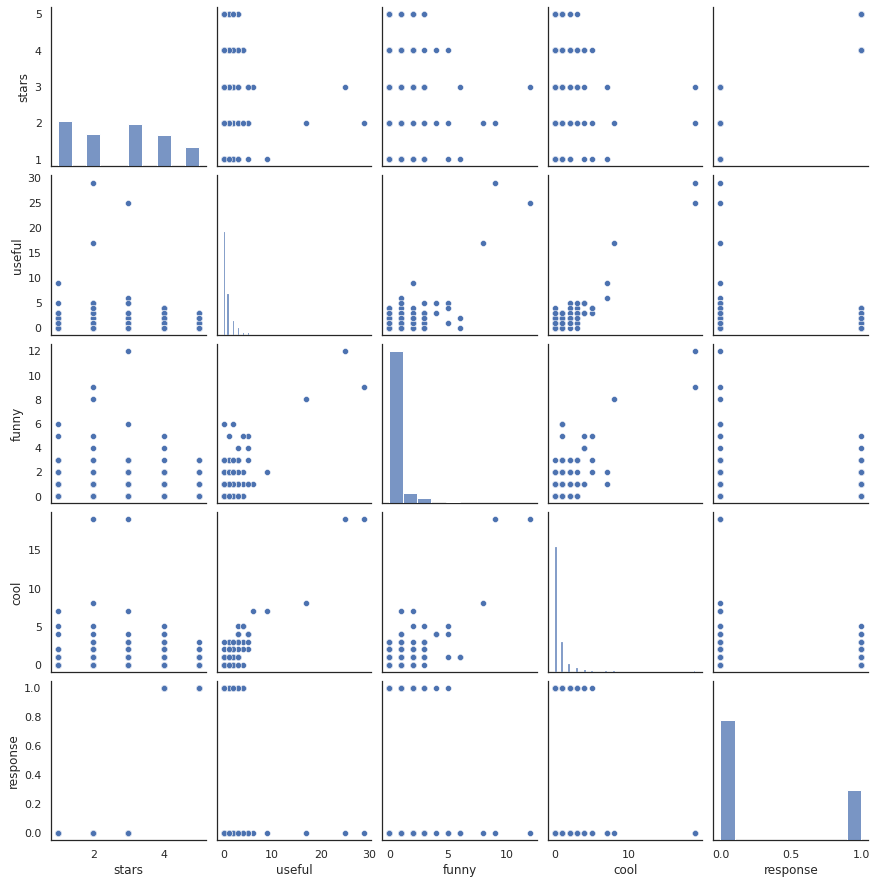

In [168]:
resp=res[res.name.isin(TopRes.index)][['business_id','name']]
resp.reset_index()

#Join the resp and reviews dataframes 
resp=pd.merge(resp,reviews,how='inner',on="business_id")

#Pair-plot for 'Tim Hortons',and 'Subways' outlets (We also plot them individually, but haven't included here).
sns.pairplot(data=resp[resp.name.isin(['Tim Hortons','Subways'])])


Text(0.5, 1.0, 'Histplot for Tim Hortons and Subway outlets')

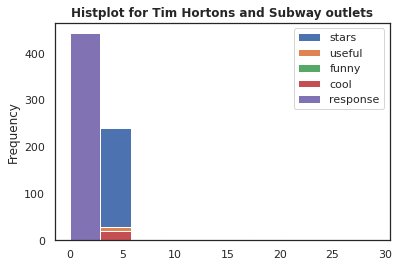

In [170]:
#Histplot for 'Tim Hortons',and 'Subways' outlets
fig = resp[resp.name.isin(['Tim Hortons','Subways'])].plot(kind='hist')
fig.set_title("Histplot for Tim Hortons and Subway outlets",weight="bold")

We observe the following from the previous graphs:
1. We get a pairplot to see the correlations  between the various columns of the review dataset based on the Tim Hortons case and we see that users who have given funny reviews,seem to have also given greater number of ratings,compared to other.
2. In case of Subway, we see that, users with cool reviews seem to have given more number of ratings to the Subways.
3. Both the Tim Hortons and Subway have obtained, good number of responses, a good number of ratings,very few useful but mostly cool reviews. These responses are majorly, because of the strong market hold of these businesses as stated and visualised earlier.

Reference- https://www.kaggle.com/jagangupta/what-s-in-a-review-yelp-ratings-eda

#### Lastly, let's look into the users with maximum reviews!

review_id     stars
                           count      mean
user_id                                   
CxDOIDnH8gp9KXzpBHJYXw       718  3.345404
Q9mA60HnY87C1TW5kjAZ6Q       451  4.024390
O3pSxv1SyHpY4qi4Q16KzA       435  3.358621
ic-tyi1jElL_umxZVh8KNA       401  3.496259

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


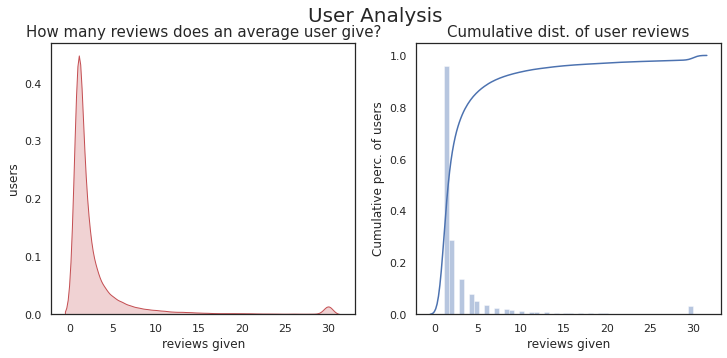

In [25]:
#Plotting the Dsitribution of user reviews

#Group reviews at the user-level and aggregate (count, average) for (review_id, stars).
user=reviews.groupby('user_id').agg({'review_id':['count'],'stars':['mean']})
user=user.sort_values([('review_id','count')],ascending=False) #sort based on count, for each user.
display(user.head(4))

user[('review_id','count')].loc[user[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Analysis",fontsize=20)


plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('reviews given', fontsize=12)
plt.ylabel('users', fontsize=12)


#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('reviews given', fontsize=12)

plt.show();

***

# Baseline Models  

<div class="alert alert-block alert-danger" style="color:black;background-color:#fffff3">
    For the baseline model, we use the formula given by <b>Koren and Bell</b> in their <b>Advanced collaborative Filtering</b> paper to obtain the user and restaurants bias and the average ratings for Toronto Restaurants across the Yelp dataset.

We make a combined dataframe of users and restaurants and from that,process the user bias and restaurant bias required for the baseline model.

In [27]:
#making a combined dataframe with the minimum required number of columns for the baseline model
combo_df = pd.merge(res[['business_id','stars']],reviews,on='business_id')
combo_df.rename(columns={'stars_x':'business_avg','stars_y':'rating'},inplace=True)

#user average rating calculation
user_avg = pd.DataFrame(combo_df.groupby('user_id')['rating'].mean())
user_avg['user_id'] = user_avg.index
user_avg.reset_index(drop=True,inplace=True)

#adding the user average rating column to the combined dataframe
combo_df = pd.merge(combo_df,user_avg,on='user_id')

#Rename the rating columns (one for the businesses, one for the users)
combo_df.rename(columns={'rating_x':'rating','rating_y':'user_avg'},inplace=True)
combo_df.head()


business_id  business_avg  ... response  user_avg
0  0QjROMVW9ACKjhSEfHqNCQ           4.0  ...        1  3.750000
1  Y9TialvINU0jf0GXaCXuiA           4.5  ...        0  3.750000
2  7oEKIG7d1ttPRejppZ3WIA           4.0  ...        1  3.750000
3  OIdOJaNS8M624F58XGV3PQ           4.0  ...        0  3.750000
4  0QjROMVW9ACKjhSEfHqNCQ           4.0  ...        1  3.619048

[5 rows x 10 columns]

In [28]:
restaurant = combo_df.business_id.unique()
user = combo_df.user_id.unique()

#extracting the business ids as index integer values for ease of linear regression
userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}

#converting the business ids to index integer values for ease of linear regression
combo_df['business_id'] = combo_df.business_id.apply(lambda x: resid2idx[x])
combo_df['user_id'] = combo_df.user_id.apply(lambda x: userid2idx[x])

In [29]:
#Test-train split
train, test = train_test_split(combo_df,train_size=0.8,random_state=2017)

In [30]:
def get_restaurant_offsets(df, rating, bus_id, bus_avg, lambda2):# a helper function to get hold of the restaurant bias
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(bus_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(bus_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda2),
                       columns=['business_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=bus_id)
    return df

In [31]:
def get_user_offsets(df, rating, user_id, user_avg, lambda3):#a helper function to get hold of the user bias
    overall_avg = df[rating].mean()
    
    #top of equation
    
    df['individualRatingMinusAverage'] = df[rating] - overall_avg #temporary column
    summedDifference = df.groupby(user_id)['individualRatingMinusAverage'].sum()
    
    df.drop('individualRatingMinusAverage',axis=1,inplace=True) #get rid of temporary column

    #bottom of equation
    ratingCount = df.groupby(user_id)[rating].count()    
    
    #final result
    bias = pd.DataFrame(data=summedDifference / (ratingCount + lambda3),
                       columns=['user_bias'])
    
    #add result back to dataframe
    df = df.join(bias,on=user_id)
    df['avg_review_stars'] = overall_avg
    return df

We do the baseline model by producing a new dataframe where the user bias and the restaurant bias is stored an both of them are obtained by controlled form using lambdas of 10,15 respectively. The lambdas are obtained in a hit and trial mode to obtain a optimum model which is neither an overfit nor an underfit.

### Baseline Model: Approach 1

We make a linear Regression using the baseline model with the train set fit and predicting on the test set. The test set has the attributes of only those restaurants that are already present in Train set.
We have two approaches in this case. One is ***Linear Regression by simply train test split*** and the other is ***Linear Regression alongwith CrossValidation while using Pipeline for the same***.

In [32]:
processed_df=pd.DataFrame()
processed_df = get_restaurant_offsets(train,'rating','business_id','business_avg',15)
processed_df = get_user_offsets(processed_df,'rating','user_id','user_avg',10)
processed_df['baseline_y'] = processed_df['business_bias'] + processed_df['user_bias'] + processed_df['avg_review_stars']

processed_df.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


business_id  business_avg  ... avg_review_stars  baseline_y
159712         1411           4.0  ...         3.669717    4.229687
269696          795           3.5  ...         3.669717    3.382049
297717          713           3.5  ...         3.669717    3.701086

[3 rows x 14 columns]

In [33]:
#Linear Regression Model

reg = LinearRegression()
X = processed_df.drop(['rating','review_id'],axis=1)
y = processed_df['rating']
model = reg.fit(X,X['baseline_y'])#fitting the model 

print("Training Error: ",mean_squared_error(y,model.predict(X)))

Training Error:  1.1459672314856646


In [34]:
#For the test case, we considering only those businesses which are there in the train set.
test = test[test.business_id.isin(X.business_id.unique())]  


#Getting hold of the businesses which are already there in the train set
test_pro_df = get_restaurant_offsets(test,'rating','business_id','business_avg',30)
test_pro_df = get_user_offsets(test_pro_df,'rating','user_id','user_avg',45)
test_pro_df['baseline_y'] = test_pro_df['business_bias'] + test_pro_df['user_bias'] + test_pro_df['avg_review_stars']

#Predicting on the test set
X_test = test_pro_df.drop(['rating','review_id'],axis=1)
y_test = test_pro_df['rating']
print("Testing Error: ",mean_squared_error(y_test,model.predict(X_test)))

Testing Error:  1.3528844990862146


rating    count      mean       std  ...       25%       50%       75%       max
0     1.0  25903.0  3.107417  0.477603  ...  2.798623  3.127547  3.430411  4.866898
1     2.0  25664.0  3.316966  0.454367  ...  3.019081  3.331336  3.635283  4.793734
2     3.0  46406.0  3.505389  0.440278  ...  3.219966  3.513128  3.813466  5.009929
3     4.0  86641.0  3.749290  0.419405  ...  3.473310  3.769375  4.046889  5.308914
4     5.0  86048.0  4.014279  0.407215  ...  3.755051  4.047289  4.299684  5.457066

[5 rows x 9 columns]

Text(0.5, 1.0, 'Predicted Ratings vs Original Ratings for Train')

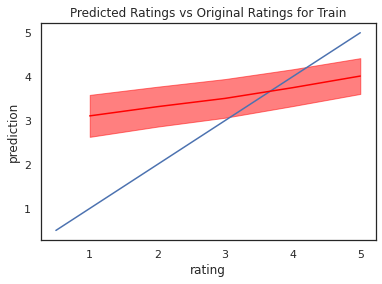

In [35]:
#Summarising the Train predictions & Plotting the ratings obtained

dfpreds = X[['business_id', 'user_id']].copy()
dfpreds['rating'] = y
dfpreds['predictions'] = model.predict(X)

#Result summary at the rating-level
preds_stats_train = dfpreds.groupby('rating')['predictions'].describe().reset_index()
display(preds_stats_train)

#Plotting the Predicted Ratings vs Original Ratings for Train
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.rating, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.rating, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('Predicted Ratings vs Original Ratings for Train')



Text(0.5, 1.0, 'Predicted Ratings vs Original Ratings for Val')

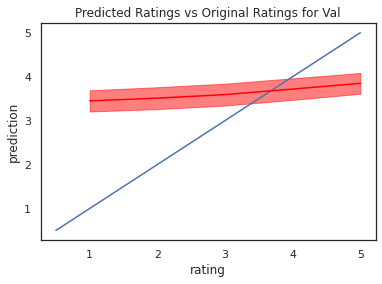

In [36]:
#Summarising the Test predictions & Plotting the ratings obtained

dfpreds = X_test[['business_id', 'user_id']].copy()
dfpreds['rating'] = y_test
dfpreds['predictions'] = model.predict(X_test)

preds_stats_val = dfpreds.groupby('rating')['predictions'].describe().reset_index()
preds_stats_val

plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.rating, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.rating, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('Predicted Ratings vs Original Ratings for Val')

### Baseline Model: Approach 2
***Linear Regression alongwith CrossValidation while using Pipeline***.

In [37]:
# Loading the boston data
X = processed_df.drop(['rating','review_id'],axis=1)
y = processed_df['rating']

# Creating a scaler object and PCA object
std_scl = StandardScaler()
pca = decomposition.PCA()


# Linear regression object with an L2 penalty
# Creating a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.


linear = linear_model.LinearRegression()
pipe = Pipeline(steps=[('std_scl', std_scl),
                        ('pca', pca),
                        ('linear', linear)]) #pipeline creation


# Creating Parameter Space
# Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X.shape[1]+1,1))

# Creating lists of parameter for Linear Regression
normalize = [True, False]

# Creating a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  linear__normalize=normalize)

# Conducting Parameter Optmization With Pipeline
# Creating a grid search object
clf = GridSearchCV(pipe, parameters)

# Fitting the grid search
clf.fit(X, X['baseline_y'])

# Viewing The Best Parameters
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['linear'])

Best Number Of Components: 10

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


In [38]:
#Train & Test Error

print("Training Error: ",mean_squared_error(y,clf.predict(X)))

#For test case, getting hold of the businesses which are already there in the train set
test_pro_df = get_restaurant_offsets(test,'rating','business_id','business_avg',30)
test_pro_df = get_user_offsets(test_pro_df,'rating','user_id','user_avg',45)
test_pro_df['baseline_y'] = test_pro_df['business_bias'] + test_pro_df['user_bias'] + test_pro_df['avg_review_stars']

#predicting on the test set
X_test = test_pro_df.drop(['rating','review_id'],axis=1)
y_test = test_pro_df['rating']
print("Testing Error: ",mean_squared_error(y_test,clf.predict(X_test)))

Training Error:  1.145967231485666
Testing Error:  1.352910754993948


rating    count      mean       std  ...       25%       50%       75%       max
0     1.0  25903.0  3.107417  0.477603  ...  2.798623  3.127547  3.430411  4.866898
1     2.0  25664.0  3.316966  0.454367  ...  3.019081  3.331336  3.635283  4.793734
2     3.0  46406.0  3.505389  0.440278  ...  3.219966  3.513128  3.813466  5.009929
3     4.0  86641.0  3.749290  0.419405  ...  3.473310  3.769375  4.046889  5.308914
4     5.0  86048.0  4.014279  0.407215  ...  3.755051  4.047289  4.299684  5.457066

[5 rows x 9 columns]

Text(0.5, 1.0, 'Predicted Ratings vs Original Ratings for Train')

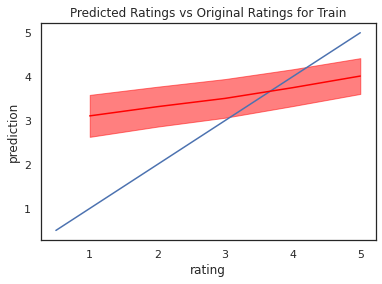

In [39]:
#Compare the predicted rating vs original rating for the train set

dfpreds = X[['business_id', 'user_id']].copy()
dfpreds['rating'] = y
dfpreds['predictions'] = clf.predict(X)

preds_stats_train = dfpreds.groupby('rating')['predictions'].describe().reset_index()
display(preds_stats_train)

#Plot
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.rating, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.rating, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('Predicted Ratings vs Original Ratings for Train')

Text(0.5, 1.0, 'Predicted Ratings vs Original Ratings for Val')

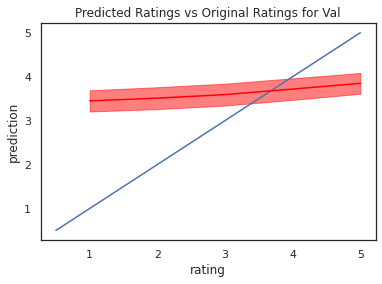

In [40]:
#Compare the predicted rating vs original rating for the train set

dfpreds = X_test[['business_id', 'user_id']].copy()
dfpreds['rating'] = y_test
dfpreds['predictions'] = model.predict(X_test)

preds_stats_val = dfpreds.groupby('rating')['predictions'].describe().reset_index()
preds_stats_val

plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.rating, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.rating, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('Predicted Ratings vs Original Ratings for Val')

# Collaborative Filtering Approach
We have two datasets. One is for the businesses:'res' dataset and one for the users :'reviews'.We used these two to make our baseline model. Now, we make the recommendation engine with these along with the residual factors.

Getting the data ready!

For Collaborative filtering, we take only the columns with good amount of correlation to do the filtering and prediction.

In [42]:
# Considering only the reviews of restaurants in Toronto
business=res.business_id.unique()
reviews=reviews[reviews.business_id.isin(business)]

#Store and load dataframe, change its index to a sequential one
reviews.to_pickle("revTor") 
reviews=pd.read_pickle('revTor')
reviews.reset_index()

index               review_id  ... cool response
0            25  mM8i91yWP1QbImEvz5ds0w  ...    0        1
1            44  nAm92_-WUQ084x9Uz9iFmA  ...    0        0
2           114  V3kZd0O3EeVuTBCKOW-M4g  ...    0        1
3           134  Lx-ervsT1BqUL7OfW-Lb9A  ...    0        1
4           148  saJUbTtnictm8KFx6cNNJA  ...    2        1
...         ...                     ...  ...  ...      ...
338323  8020622  9lEYzla0NLZyMsNV-b53Qg  ...    1        0
338324  8020639  rBfr17beQCItyFrqdxOFEw  ...    0        1
338325  8020643  X9a03IeCFtSeI1fOaicE2g  ...    1        1
338326  8020780  2By_gXjZCbiEE1ZTO6hDcQ  ...    4        1
338327  8021088  a1wtLsOkcWWOFlXQLdtVVg  ...    0        0

[338328 rows x 9 columns]

In [43]:
restaurant = res.business_id.unique()
user = reviews.user_id.unique()

#mapping the index of the users and restaurants to replace them with their indexes in the dataset
userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}

#making two new columns for the business and user ids to replace with the extracted indexes
reviews['business_id'] = reviews.business_id.apply(lambda x: resid2idx[x])
reviews['user_id'] = reviews.user_id.apply(lambda x: userid2idx[x])

#making the id column for the restaurants
res = res[res.business_id.isin(restaurant)]
res['id'] = res.business_id.apply(lambda x: resid2idx[x])


res = res.drop('business_id', axis=1).set_index('id')
res.head(3)
#completed the transformation


name postal_code  ...  dr_soy-free  dr_vegetarian
id                                ...                            
0   Mi Mi Restaurant     M4M 1Y3  ...            0              0
1        Tim Hortons     M5H 3V9  ...            0              0
2        Chick-N-Joy     M3A 1Z3  ...            0              0

[3 rows x 78 columns]

In [44]:
#Viewing the reviews dataframe
reviews.sort_values(by='user_id')

restaurant_names = res.name.to_dict() #transformed key:restaurant name
reviews = reviews.merge(res,left_on="business_id",right_on="id")
reviews.rename(columns={'stars_x':'rating','stars_y':'business_avg'},inplace=True)
reviews.head()

review_id  user_id  ...  dr_soy-free  dr_vegetarian
0  mM8i91yWP1QbImEvz5ds0w        0  ...            0              0
1  JFSu748xDxsT3SSeEKc5pg      404  ...            0              0
2  uQ1ECZKa24lHUov_BsXfVg      538  ...            0              0
3  Fg5giQo4w776Q2NgHe4jIw      836  ...            0              0
4  efL6dh7WnJT9wIPs2raulg     1065  ...            0              0

[5 rows x 86 columns]

In [45]:
reviews.to_csv("ratings_contig.csv", index=False)
res.to_csv("restaurants_contig.csv", index=False)

nusers = reviews.user_id.nunique()
nresto = reviews.business_id.nunique()#number of restaurants that have been rated
nusers, nresto

(90665, 5462)

In [46]:
np.random.seed=2017

#Splitting the reviews dataset in 80:20 ratio
train_indices, val_indices = train_test_split(range(reviews.shape[0]), train_size=0.8)

#the data obtained
trdf = reviews.iloc[train_indices]
valdf = reviews.iloc[val_indices]
print(trdf.shape, valdf.shape)

#Regularisation metrics for the embedding matrix
L=30
REG=5e-4

(270662, 86) (67666, 86)


In [47]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [48]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [49]:
#obtaining the latent factor matrices and the inputs required to create the bias
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
res_input, rLmat = embedding_input('res_input', nresto, L, REG)

#creating the offsets
user_bias = create_bias('user_bias', user_input, nusers, REG)
res_bias = create_bias('res_bias', res_input, nresto, REG)

#the residual factors
residual = Dot(axes=2, name="residual")([uLmat, rLmat])

#flattened to be used for the linear regression model
residflat = Flatten(name="residual_flat")(residual)
residflat.shape


TensorShape([None, 1])

In [50]:
#custom sigma function to limit the predictions within 0 and 5
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid



In [51]:
#Modeling

#linear regression model for rating prediction
regression = Add(name="regression")([user_bias, res_bias,residflat])

#custom sigma function to limit the predictions within 0 and 5
cs = sigmoid_maker(0, 5)

output = Activation(cs, name="Sigmoid_Range")(regression)
model = Model([user_input, res_input], output)
model.compile(Adam(0.001), loss='mse', metrics=[tf.keras.metrics.Accuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
res_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 30)        2719950     user_input[0][0]                 
__________________________________________________________________________________________________
res_factor (Embedding)          (None, 1, 30)        163860      res_input[0][0]                  
______________________________________________________________________________________________

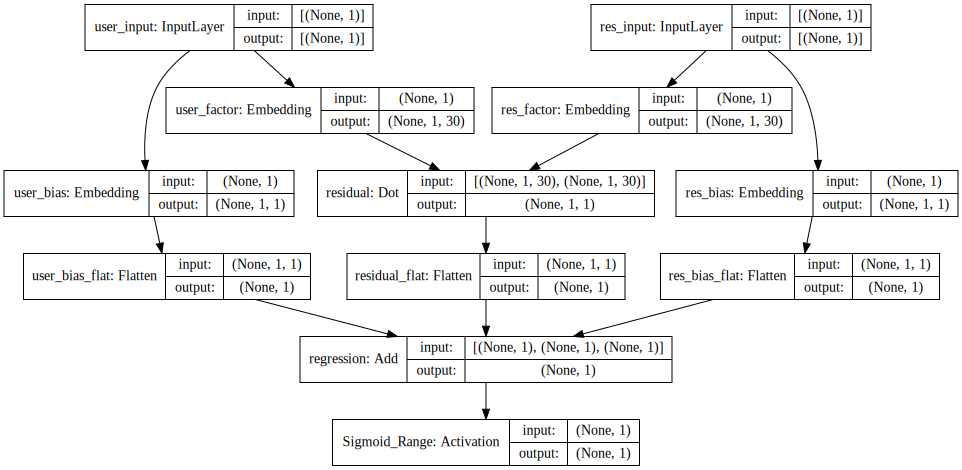

In [52]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [53]:
#Fit the model, across different learning rates
histdict={}
lr=[0.01,0.001]

for i in lr:

    model.optimizer.lr = i
    histdict[i] = model.fit([trdf.user_id, trdf.business_id], trdf.rating, batch_size=64,epochs=4,validation_data=([valdf.user_id, valdf.business_id],valdf.rating))
    

Epoch 1/4
4230/4230 [==============================] - 153s 36ms/step - loss: 1.8626 - val_loss: 1.3677
Epoch 2/4
4230/4230 [==============================] - 152s 36ms/step - loss: 1.1157 - val_loss: 1.3881
Epoch 3/4
4230/4230 [==============================] - 142s 34ms/step - loss: 0.9695 - val_loss: 1.4256
Epoch 4/4
4230/4230 [==============================] - 141s 33ms/step - loss: 0.8826 - val_loss: 1.4589
Epoch 1/4
4230/4230 [==============================] - 141s 33ms/step - loss: 0.7813 - val_loss: 1.4448
Epoch 2/4
4230/4230 [==============================] - 141s 33ms/step - loss: 0.7663 - val_loss: 1.4432
Epoch 3/4
4230/4230 [==============================] - 141s 33ms/step - loss: 0.7582 - val_loss: 1.4441
Epoch 4/4
4230/4230 [==============================] - 140s 33ms/step - loss: 0.7525 - val_loss: 1.4462


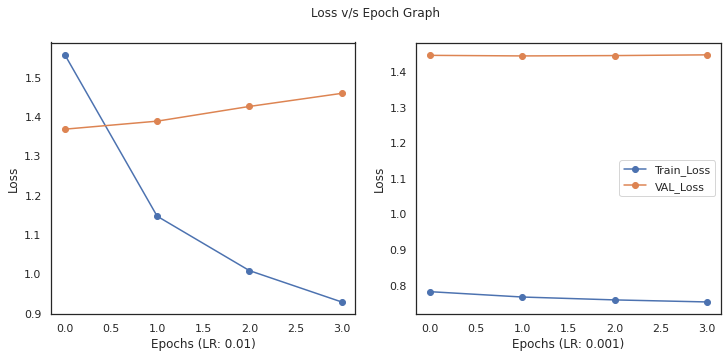

In [117]:
#Plotting train and val loss

fig , ax = plt.subplots(1,2,figsize=(12,5)) 

fig.suptitle("Loss v/s Epoch Graph")

ax[0].set_xlabel("Epochs (LR: 0.01)")
ax[1].set_xlabel("Epochs (LR: 0.001)")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Loss")

ax[0].plot(histdict[0.01].history['loss'],label="Train_Loss",marker='o')
ax[0].plot(histdict[0.01].history['val_loss'],label="VAL_Loss",marker='o')


ax[1].plot(histdict[0.001].history['loss'],label="Train_Loss",marker='o')

ax[1].plot(histdict[0.001].history['val_loss'],label="VAL_Loss",marker='o')
plt.legend()

The model with a learning rate of 0.001 with epoch 4 seems to overfitting to some extent as the validation loss is almost twice the training loss.

This too, doesn't seem to do any better. There is a slight amount of improvement in the overfitting as it seems to less-overfit compared to the previous case.

## Recommender in Action
### Now that we're done with modeling, let's see how the predictions for a single user look like

In [56]:
# We are considering the user having a User ID of 4
dfuser4 = reviews[(reviews['user_id']==4)]
dfuser4.head()

review_id  user_id  ...  dr_soy-free  dr_vegetarian
1141   saJUbTtnictm8KFx6cNNJA        4  ...            0              0
20320  llfIjSMsA6eccqpA4tbUjw        4  ...            0              0
45986  WwFJsNk4NYCJ7Wm-L1VN3Q        4  ...            0              0
51093  5odajqzCHXQf1j2OGe5aAw        4  ...            0              0
86139  Xqmnqr-OHiuOhp2GwjSvbw        4  ...            0              0

[5 rows x 86 columns]

In [91]:
res_not = list(set(res.index) - set(dfuser4.business_id))
print(len(res_not))

dfuser4['predictions'] = model.predict([dfuser4.user_id, dfuser4.business_id]).ravel()
predictions = model.predict([np.array([4]*len(res_not)), np.array(res_not)]).ravel()
print(predictions)

#Obtain top restaraunts (for User-4) based on the highest prediction scores!
dfuser4preds = pd.DataFrame(dict(
    business_id = res_not,
    predictions = predictions
))
dfuser4preds['restaurant'] = dfuser4preds.business_id.apply(lambda x: restaurant_names[x])
dfuser4preds['userId'] = 4
display(dfuser4preds.sort_values('predictions', ascending=False))

#Predictions
dfpreds = reviews[['business_id', 'rating', 'user_id','response']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()


5447
[3.7675297 2.8533509 2.273367  ... 3.6354592 4.196015  2.5720053]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


business_id  ...  userId
1284         1288  ...       4
5156         5170  ...       4
4520         4533  ...       4
1153         1157  ...       4
1333         1338  ...       4
...           ...  ...     ...
56             56  ...       4
5104         5118  ...       4
2592         2599  ...       4
3475         3486  ...       4
1572         1577  ...       4

[5447 rows x 4 columns]

Text(0, 0.5, 'prediction')

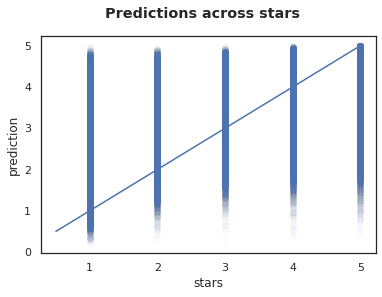

In [173]:
#Plot predictions across stars
plt.scatter(dfpreds.rating, dfpreds.predictions, alpha=0.01)
plt.suptitle("Predictions across stars",weight="bold")
plt.plot([0.5,5],[0.5,5])
plt.xlabel("stars")
plt.ylabel("prediction")

The predictions, as expected based on the validation loss, don't seem to do a great job.

In [93]:
#Distributions of the predictions
preds_stats=dfpreds.groupby('rating')['predictions'].describe().reset_index()
display(preds_stats)

#For Train
preds_stats_train = dfpreds.iloc[train_indices].groupby('rating')['predictions'].describe().reset_index()
display(preds_stats_train)

#For validation
preds_stats_val = dfpreds.iloc[val_indices].groupby('rating')['predictions'].describe().reset_index()
preds_stats_val


rating     count      mean       std  ...       25%       50%       75%       max
0     1.0   32329.0  2.336927  0.989379  ...  1.479240  2.243644  3.112111  4.985739
1     2.0   32204.0  2.951605  0.776071  ...  2.297698  2.986675  3.533986  4.958081
2     3.0   57906.0  3.415835  0.584629  ...  3.020855  3.421848  3.832188  4.987254
3     4.0  108510.0  3.819738  0.513907  ...  3.541825  3.907048  4.154602  4.995040
4     5.0  107379.0  4.228786  0.550949  ...  3.960396  4.355210  4.631513  4.999039

[5 rows x 9 columns]

rating    count      mean       std  ...       25%       50%       75%       max
0     1.0  25816.0  2.173053  0.932713  ...  1.386445  2.014917  2.887626  4.932456
1     2.0  25730.0  2.873363  0.754916  ...  2.196116  2.890081  3.450390  4.932971
2     3.0  46305.0  3.398613  0.560432  ...  3.012403  3.394692  3.799043  4.987254
3     4.0  86712.0  3.841937  0.478298  ...  3.581417  3.924500  4.150681  4.982341
4     5.0  86099.0  4.300998  0.486062  ...  4.058580  4.407699  4.659025  4.999039

[5 rows x 9 columns]

rating    count      mean       std  ...       25%       50%       75%       max
0     1.0   6513.0  2.986572  0.939255  ...  2.400290  3.061723  3.662922  4.985739
1     2.0   6474.0  3.262618  0.781053  ...  2.789223  3.316561  3.812434  4.958081
2     3.0  11601.0  3.484508  0.668221  ...  3.088542  3.532422  3.959985  4.983178
3     4.0  21798.0  3.731415  0.628425  ...  3.366550  3.810257  4.176946  4.995040
4     5.0  21280.0  3.936457  0.685017  ...  3.568421  4.058471  4.449395  4.997999

[5 rows x 9 columns]

Text(0, 0.5, 'prediction')

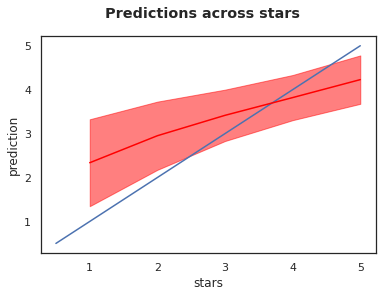

In [174]:
#Plotting the prediction across stars
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.rating, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.rating, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)

plt.suptitle("Predictions across stars",weight="bold")
plt.xlabel("stars")
plt.ylabel("prediction")

In this graph, we understand that our model does well in cases where the rating is somewhere close to 4 i.e (3.5,4.5) region and in the rest areas, it does terribly bad.

Text(0, 0.5, 'prediction')

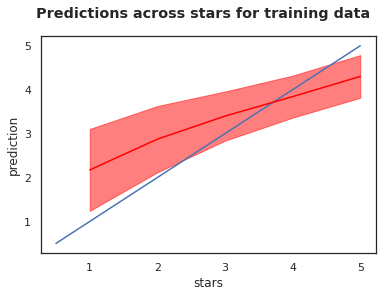

In [176]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.rating, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.rating, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)

plt.suptitle("Predictions across stars for training data",weight="bold")
plt.xlabel("stars")
plt.ylabel("prediction")


Text(0.5, 0.98, 'Predictions across stars for validation data')

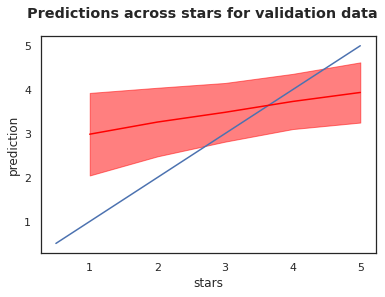

In [177]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.rating, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.rating, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.suptitle("Predictions across stars for validation data",weight="bold")

In [187]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    fig = sns.heatmap(cm)

    fig.set_title('Confusion matrix on Validation Data')
    fig.set_ylabel('Observed label')
    fig.set_xlabel('Predicted label')

    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]

    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])

    print("--------------------")

    Accuracy = (TP+TN)/(TP+FP+FN+TN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1_Score = 2*(Recall * Precision) / (Recall + Precision)

    print("Accuracy: ",Accuracy)
    print("Precision: ",Precision)
    print("Recall: ", Recall)
    print("F1 Score: ",F1_Score)

 

To define the True Positives(TP) we are thresholding the predictions. So we put the threshold at 3.5 like we did before

In [188]:
preds = dfpreds.iloc[val_indices]

preds['pred_response'] = [1 if y>3.5 else 0 for y in preds['predictions']]

preds.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


business_id  rating  user_id  response  predictions  pred_response
32631           678     4.0     6680         1     3.675215              1
245521         3988     2.0    23011         0     3.088709              0
114616         1937     4.0     2328         1     3.668514              1
300261         4425     5.0    78929         1     4.633127              1
254640         3882     4.0     1614         1     4.517216              1

True positive =  13931
False positive =  10657
False negative =  11561
True negative =  31517
--------------------
Accuracy:  0.671651937457512
Precision:  0.5665771921262405
Recall:  0.5464851718186098
F1 Score:  0.5563498402555911


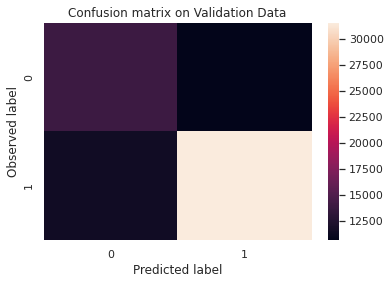

In [189]:
print_confusion_matrix(preds['response'],preds['pred_response'])

Out of the 4 cases, the following are undesirable (from a business standpoint:
1. False Positives: We want to avoid as many of these as possible, since sending a person to a not-so-good restaurant would defeat the purpose of having a good recommender (and even affect our brand value).
2. False Negatives: It is still better to have FN than FP (although this could pose an issue if we’ve partnered with the restaurants). Having more FNs indicates that the users are being denied recommendation of potentially good restaurants. While this won’t affect the customer much (the person can get alternate good recess), this could pose a loss for the good hotels which have been deemed bad.
In our case, it’s good that FPs are the least of the lot.

Specifically in the test cases, the model predicts somewhere close to the actual ratings, whereas in the lower ratings, it doesn't do a great job.

***
## Additional Baseline (Using Tips Instead of Reviews)

<div class="alert alert-block alert-danger" style="color:black;background-color:#fffff3">
We want a combined dataframe to predict user average_stars. To this end, we proceed with the following steps:
<ul>
   <li> 1. Get business id for users_df- this can be done by merging the tip dataset with user dataset. We want to do this to get keys for the next merge. </li> 
<li> 2. Using the business id, we want to merge with business dataset and get the review count for prediction. </li> 
    <li> 3. Our response variable will be average user rating for this sub-section. </li> 
    <li> 4. Perform the train-test split. </li> 
    <li> 5. Predict y, the response. </li>
    </ul>

In [65]:
#Select features for our baseline model
baseline_toronto_df = pd.read_pickle('Toronto_rest')
baseline_toronto_df = baseline_toronto_df[['business_id', 'stars', 'review_count']]

#Load the tips dataset
tip_df = read_json(tip_json_path)
display(tip_df.head())

user_id  ... compliment_count
0  hf27xTME3EiCp6NL6VtWZQ  ...                0
1  uEvusDwoSymbJJ0auR3muQ  ...                0
2  AY-laIws3S7YXNl_f_D6rQ  ...                0
3  Ue_7yUlkEbX4AhnYdUfL7g  ...                0
4  LltbT_fUMqZ-ZJP-vJ84IQ  ...                0

[5 rows x 5 columns]

In [68]:
#Obtain User IDs and Business IDs from tip df 
id_df = tip_df[['user_id', 'business_id']]
id_df.shape

#merging the previous ID dataframe with our baseline_user dataframe (Step 2 in the description)

baseline_user_df = pd.read_pickle('baseline_user_df.pkl')
combined_df = id_df.merge(baseline_user_df, how='inner', on='user_id')

#Re-naming the new column to review_count_user, since this is at the user-level.
combined_df = combined_df.rename(columns = {'review_count' : 'review_count_user'})

#Inner join the combined_df dataframe, with our baseline resturant dataframe. 
df = combined_df.merge(baseline_toronto_df, how='inner', on='business_id')
print(df.shape)

#Report for the small dataframe that we will use to make our baseline classifier!
table_report(df)

(4490, 8)
Table Shape (4490, 8)


In [69]:
# Indicator and Response variables for our baseline


y = df['average_stars'] #Our response variable is average_stars
#Dropping all id related columns to make a prediction using only the select columns
x = df.drop(columns = ['average_stars', 'business_id', 'user_id'], axis=1)

print(x.shape, y.shape)
display(x.head(3))

(4490, 5) (4490,)


review_count_user  fans  compliment_plain  stars  review_count
0                988   419              4508    3.0           125
1                447    36                99    3.0           125
2               1921   101               321    3.0           125

In [70]:
#Train-test split (80-20)
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42)
print( x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#Standardize the data: Fit on x_train, and transform on both, x_train and x_test.
#Note: Only the parameters obtained from fitting on train data are taken for further transforms.
scaler = StandardScaler().fit(x_train) 
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

(3592, 5) (898, 5) (3592,) (898,)


In [71]:
#Linear Regression 
lreg = LinearRegression()
lreg.fit(X_train, y_train)
y_train_pred = lreg.predict(X_train)
y_test_pred = lreg.predict(X_test)

#Computing the MSE for test and train datasets
mse_train = mean_squared_error(y_train_pred, y_train)
mse_test =mean_squared_error(y_test_pred, y_test)
print("The mean squared error on the training set is :",mse_train, "and the test set is:",mse_test)


The mean squared error on the training set is : 0.06601455726938746 and the test set is: 0.06102156906586283


### Let's Visualise our Predictions for the Baseline-1 Model!

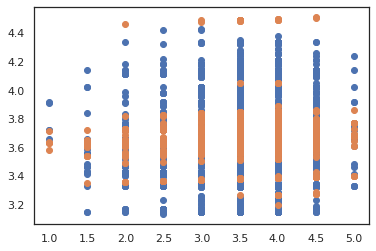

In [72]:
plt.scatter(x_train.stars, y_train)
plt.scatter(x_train.stars, y_train_pred)


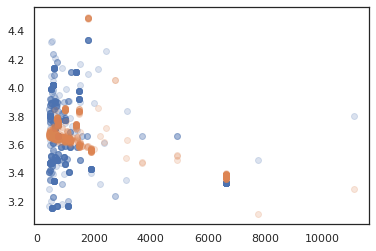

In [73]:
plt.scatter(x_test.review_count_user, y_test, alpha=0.2)
plt.scatter(x_test.review_count_user, y_test_pred, alpha=0.2)

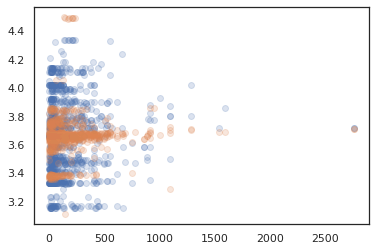

In [74]:
plt.scatter(x_test.review_count, y_test, alpha=0.2)
plt.scatter(x_test.review_count, y_test_pred, alpha=0.2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


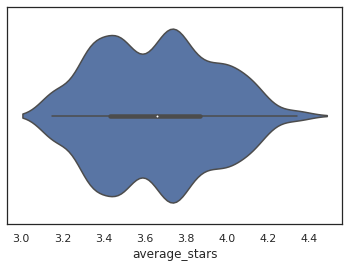

In [75]:
sns.violinplot(y_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


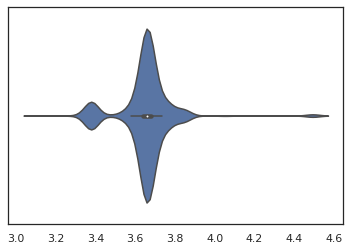

In [76]:
sns.violinplot(y_test_pred)

From the above models we can see that our mse score is pretty good but the problem with the model is not the mse score, rather the distribution of its predicitons. 
The distriution of predictions lie between 3.6 to 3.8. We want a model that can accurately predict high user rating, the model also has no information about low scores, although that is not as important to us as the high scores are. 

***

# Results & Conclusion


<div class="alert alert-block alert-danger" style="color:black;background-color:#ffffa1">
<h2 style="color:black;background-color:#ffffa1"> Conclusion and Takeaways </h2>    <br />

 <ul>
     <li> <b>Collaborative Filtering Inference: The learning rate of 0.01 is a better option than the learning rate of 0.001 </b> as the graph suggests, the train loss keeps minimising and the test loss, after a certain point starts increasing. The graph shows that the model is neither underfitting nor overfitting in this case compared to the learning rate of 0.001,which is slow and shows no decrement in test loss or in train loss(which seems to be consistent and lesser than the test loss all throughout) </li>
<li> <b>Predictions:
    The model does a great job in predicting ratings between 3.5-4.5 or less </b> as the yelp dataset has a rating concentration of 90% in this range. As a result, due to insufficient data wrt the lower ratings, the model fails to predict well in the lower rating range.</li>
     <li> <b> Pca</b>:
The Pca shows the three principal components which have the highest co-variance ratio with the predictions and clearly shows that instead of using a 50 dimensional latent space, we could have easily done it using only those 3 components whose features are extracted. </li>
<li> <b> Conclusion:
The model, that we have made predicts the ratings for the restaurants that the user hasn't been to and recommends them according to the ratings that he might give to them. The test loss is around 1.42 and the train loss is almost half of it. The PCA doesn't really tell us much about the restaurants but helps us to find the item item similarity. The future prospects of this project will be to feature engineer further, find the radial distance between the geospatial positions of the user and restaurants and recommend him restaurants nearby!  </b>
     </li> </ul>

## Future Work
1. Defining a location module: We could perform some sort of clustering (e.g. k-means) and create a categorical feature the user-business-review entries based on average radial distance using latitude and longitude. After all, in a real-world scenario, we would want predictions which are geographically within ~20 km, when it comes to restaurants!
2. Using more advanced forms of collaborative and content filtering. 
3. Defining better True Positive case conditions. 
4. Extending our approach across geographies.